# Machine Learning Practical: Coursework 3 working on CIFAR-10
## Baseline experiments

In [2]:
import os
import time
import tensorflow as tf
import numpy as np
from mlp.data_providers import CIFAR10DataProvider, CIFAR100DataProvider
import matplotlib.pyplot as plt
%matplotlib inline

### Experiment 1:  Exploring different activation functions

In [2]:
seed = 24102016 
rng = np.random.RandomState(seed)
train_data = CIFAR10DataProvider('train', batch_size=50, rng=rng)
valid_data = CIFAR10DataProvider('valid', batch_size=50, rng=rng)

#### 1-1. Using ReLU as activation function on CIFAR-10

In [3]:
def fully_connected_layer(inputs, input_dim, output_dim, nonlinearity=tf.nn.relu):
    weights = tf.Variable(
        tf.truncated_normal(
            [input_dim, output_dim], stddev=2. / (input_dim + output_dim)**0.5), 
        'weights')
    biases = tf.Variable(tf.zeros([output_dim]), 'biases')
    outputs = nonlinearity(tf.matmul(inputs, weights) + biases)
    return outputs

train_data.reset()
valid_data.reset()
tf.reset_default_graph()

inputs = tf.placeholder(tf.float32, [None, train_data.inputs.shape[1]], 'inputs')
targets = tf.placeholder(tf.float32, [None, train_data.num_classes], 'targets')
#note
num_hidden = 300

#note
with tf.name_scope('fc-layer-1'):
    hidden_1 = fully_connected_layer(inputs, train_data.inputs.shape[1], num_hidden)
with tf.name_scope('fc-layer-2'):
    hidden_2 = fully_connected_layer(hidden_1, num_hidden, num_hidden)
with tf.name_scope('fc-layer-3'):
    hidden_3 = fully_connected_layer(hidden_2, num_hidden, num_hidden)
with tf.name_scope('output-layer'):
    outputs = fully_connected_layer(hidden_3, num_hidden, train_data.num_classes, tf.identity)

with tf.name_scope('error'):
    error = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(outputs, targets))
with tf.name_scope('accuracy'):
    accuracy = tf.reduce_mean(tf.cast(
            tf.equal(tf.argmax(outputs, 1), tf.argmax(targets, 1)), 
            tf.float32))
#note
with tf.name_scope('train'):
    train_step = tf.train.AdamOptimizer(learning_rate = 0.0001, epsilon = 0.001).minimize(error)
    
init = tf.global_variables_initializer()

In [4]:
#note
train_stats_ex1_1 = {'epoch_num':[], 'error':[], 'acc':[], 'runningtime':[]}
valid_stats_ex1_1 = {'epoch_num':[], 'error':[], 'acc':[], 'runningtime':[]}
with tf.Session() as sess:
    sess.run(init)
    valid_time = 0.
    #note
    for e in range(50):
        start_time = time.time()
        if valid_time == 0.:
            valid_time = time.time()
        running_error = 0.
        running_accuracy = 0.
        for input_batch, target_batch in train_data:
            _, batch_error, batch_acc = sess.run(
                [train_step, error, accuracy], 
                feed_dict={inputs: input_batch, targets: target_batch})
            running_error += batch_error
            running_accuracy += batch_acc
        running_error /= train_data.num_batches
        running_accuracy /= train_data.num_batches
        epoch_time = time.time() - start_time
        #note
        train_stats_ex1_1['runningtime'].append(epoch_time)
        print('Epoch {0:02d}: {1:.2f}s to complete'.format(e + 1, epoch_time))
        print('End of epoch {0:02d}: err(train)={1:.2f} acc(train)={2:.2f}'
              .format(e + 1, running_error, running_accuracy))
        train_stats_ex1_1['epoch_num'].append(e + 1)
        train_stats_ex1_1['error'].append(running_error)
        train_stats_ex1_1['acc'].append(running_accuracy)
        if (e + 1) % 5 == 0:
            valid_error = 0.
            valid_accuracy = 0.
            for input_batch, target_batch in valid_data:
                batch_error, batch_acc = sess.run(
                    [error, accuracy], 
                    feed_dict={inputs: input_batch, targets: target_batch})
                valid_error += batch_error
                valid_accuracy += batch_acc
            valid_error /= valid_data.num_batches
            valid_accuracy /= valid_data.num_batches
            valid_time = time.time() - valid_time
            print('                 err(valid)={0:.2f} acc(valid)={1:.2f}'
                   .format(valid_error, valid_accuracy))
            #note
            valid_stats_ex1_1['epoch_num'].append(e + 1)
            valid_stats_ex1_1['error'].append(valid_error)
            valid_stats_ex1_1['acc'].append(valid_accuracy)
            valid_stats_ex1_1['runningtime'].append(valid_time)
            valid_time = 0.

Epoch 01: 12.19s to complete
End of epoch 01: err(train)=1.89 acc(train)=0.33
Epoch 02: 11.58s to complete
End of epoch 02: err(train)=1.69 acc(train)=0.40
Epoch 03: 11.63s to complete
End of epoch 03: err(train)=1.60 acc(train)=0.43
Epoch 04: 11.49s to complete
End of epoch 04: err(train)=1.54 acc(train)=0.45
Epoch 05: 11.47s to complete
End of epoch 05: err(train)=1.49 acc(train)=0.47
                 err(valid)=1.51 acc(valid)=0.47
Epoch 06: 11.74s to complete
End of epoch 06: err(train)=1.46 acc(train)=0.48
Epoch 07: 12.32s to complete
End of epoch 07: err(train)=1.42 acc(train)=0.50
Epoch 08: 12.83s to complete
End of epoch 08: err(train)=1.38 acc(train)=0.51
Epoch 09: 14.46s to complete
End of epoch 09: err(train)=1.36 acc(train)=0.52
Epoch 10: 15.22s to complete
End of epoch 10: err(train)=1.33 acc(train)=0.53
                 err(valid)=1.45 acc(valid)=0.49
Epoch 11: 15.57s to complete
End of epoch 11: err(train)=1.31 acc(train)=0.54
Epoch 12: 14.04s to complete
End of epoch 12

#### 1-2. Using logistic sigmoid as activation function on CIFAR-10

In [5]:
def fully_connected_layer(inputs, input_dim, output_dim, nonlinearity=tf.sigmoid):
    weights = tf.Variable(
        tf.truncated_normal(
            [input_dim, output_dim], stddev=2. / (input_dim + output_dim)**0.5), 
        'weights')
    biases = tf.Variable(tf.zeros([output_dim]), 'biases')
    outputs = nonlinearity(tf.matmul(inputs, weights) + biases)
    return outputs


train_data.reset()
valid_data.reset()
tf.reset_default_graph()

inputs = tf.placeholder(tf.float32, [None, train_data.inputs.shape[1]], 'inputs')
targets = tf.placeholder(tf.float32, [None, train_data.num_classes], 'targets')
#note
num_hidden = 300

#note
with tf.name_scope('fc-layer-1'):
    hidden_1 = fully_connected_layer(inputs, train_data.inputs.shape[1], num_hidden)
with tf.name_scope('fc-layer-2'):
    hidden_2 = fully_connected_layer(hidden_1, num_hidden, num_hidden)
with tf.name_scope('fc-layer-3'):
    hidden_3 = fully_connected_layer(hidden_2, num_hidden, num_hidden)
with tf.name_scope('output-layer'):
    outputs = fully_connected_layer(hidden_3, num_hidden, train_data.num_classes, tf.identity)

with tf.name_scope('error'):
    error = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(outputs, targets))
with tf.name_scope('accuracy'):
    accuracy = tf.reduce_mean(tf.cast(
            tf.equal(tf.argmax(outputs, 1), tf.argmax(targets, 1)), 
            tf.float32))
#note
with tf.name_scope('train'):
    train_step = tf.train.AdamOptimizer(learning_rate = 0.0001, epsilon = 0.001).minimize(error)
    
init = tf.global_variables_initializer()



In [6]:
#note
train_stats_ex1_2 = {'epoch_num':[], 'error':[], 'acc':[], 'runningtime':[]}
valid_stats_ex1_2 = {'epoch_num':[], 'error':[], 'acc':[], 'runningtime':[]}
with tf.Session() as sess:
    sess.run(init)
    valid_time = 0.
    #note
    for e in range(50):
        start_time = time.time()
        if valid_time == 0.:
            valid_time = time.time()
        running_error = 0.
        running_accuracy = 0.
        for input_batch, target_batch in train_data:
            _, batch_error, batch_acc = sess.run(
                [train_step, error, accuracy], 
                feed_dict={inputs: input_batch, targets: target_batch})
            running_error += batch_error
            running_accuracy += batch_acc
        running_error /= train_data.num_batches
        running_accuracy /= train_data.num_batches
        epoch_time = time.time() - start_time
        #note
        train_stats_ex1_2['runningtime'].append(epoch_time)
        print('Epoch {0:02d}: {1:.2f}s to complete'.format(e + 1, epoch_time))
        print('End of epoch {0:02d}: err(train)={1:.2f} acc(train)={2:.2f}'
              .format(e + 1, running_error, running_accuracy))
        train_stats_ex1_2['epoch_num'].append(e + 1)
        train_stats_ex1_2['error'].append(running_error)
        train_stats_ex1_2['acc'].append(running_accuracy)
        if (e + 1) % 5 == 0:
            valid_error = 0.
            valid_accuracy = 0.
            for input_batch, target_batch in valid_data:
                batch_error, batch_acc = sess.run(
                    [error, accuracy], 
                    feed_dict={inputs: input_batch, targets: target_batch})
                valid_error += batch_error
                valid_accuracy += batch_acc
            valid_error /= valid_data.num_batches
            valid_accuracy /= valid_data.num_batches
            valid_time = time.time() - valid_time
            print('                 err(valid)={0:.2f} acc(valid)={1:.2f}'
                   .format(valid_error, valid_accuracy))
            #note
            valid_stats_ex1_2['epoch_num'].append(e + 1)
            valid_stats_ex1_2['error'].append(valid_error)
            valid_stats_ex1_2['acc'].append(valid_accuracy)
            valid_stats_ex1_2['runningtime'].append(valid_time)
            valid_time = 0.

Epoch 01: 12.60s to complete
End of epoch 01: err(train)=2.29 acc(train)=0.14
Epoch 02: 12.44s to complete
End of epoch 02: err(train)=2.14 acc(train)=0.23
Epoch 03: 12.74s to complete
End of epoch 03: err(train)=2.00 acc(train)=0.28
Epoch 04: 12.41s to complete
End of epoch 04: err(train)=1.93 acc(train)=0.31
Epoch 05: 12.85s to complete
End of epoch 05: err(train)=1.89 acc(train)=0.32
                 err(valid)=1.88 acc(valid)=0.33
Epoch 06: 12.64s to complete
End of epoch 06: err(train)=1.86 acc(train)=0.34
Epoch 07: 11.86s to complete
End of epoch 07: err(train)=1.83 acc(train)=0.35
Epoch 08: 11.85s to complete
End of epoch 08: err(train)=1.80 acc(train)=0.36
Epoch 09: 11.44s to complete
End of epoch 09: err(train)=1.77 acc(train)=0.37
Epoch 10: 11.45s to complete
End of epoch 10: err(train)=1.75 acc(train)=0.37
                 err(valid)=1.75 acc(valid)=0.38
Epoch 11: 11.43s to complete
End of epoch 11: err(train)=1.73 acc(train)=0.38
Epoch 12: 11.48s to complete
End of epoch 12

#### 1-3. Using tanh as activation function on CIFAR-10

In [7]:
def fully_connected_layer(inputs, input_dim, output_dim, nonlinearity=tf.tanh):
    weights = tf.Variable(
        tf.truncated_normal(
            [input_dim, output_dim], stddev=2. / (input_dim + output_dim)**0.5), 
        'weights')
    biases = tf.Variable(tf.zeros([output_dim]), 'biases')
    outputs = nonlinearity(tf.matmul(inputs, weights) + biases)
    return outputs


train_data.reset()
valid_data.reset()
tf.reset_default_graph()

inputs = tf.placeholder(tf.float32, [None, train_data.inputs.shape[1]], 'inputs')
targets = tf.placeholder(tf.float32, [None, train_data.num_classes], 'targets')
#note
num_hidden = 300

#note
with tf.name_scope('fc-layer-1'):
    hidden_1 = fully_connected_layer(inputs, train_data.inputs.shape[1], num_hidden)
with tf.name_scope('fc-layer-2'):
    hidden_2 = fully_connected_layer(hidden_1, num_hidden, num_hidden)
with tf.name_scope('fc-layer-3'):
    hidden_3 = fully_connected_layer(hidden_2, num_hidden, num_hidden)
with tf.name_scope('output-layer'):
    outputs = fully_connected_layer(hidden_3, num_hidden, train_data.num_classes, tf.identity)

with tf.name_scope('error'):
    error = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(outputs, targets))
with tf.name_scope('accuracy'):
    accuracy = tf.reduce_mean(tf.cast(
            tf.equal(tf.argmax(outputs, 1), tf.argmax(targets, 1)), 
            tf.float32))
#note
with tf.name_scope('train'):
    train_step = tf.train.AdamOptimizer(learning_rate = 0.0001, epsilon = 0.001).minimize(error)
    
init = tf.global_variables_initializer()

In [8]:
#note
train_stats_ex1_3 = {'epoch_num':[], 'error':[], 'acc':[], 'runningtime':[]}
valid_stats_ex1_3 = {'epoch_num':[], 'error':[], 'acc':[], 'runningtime':[]}
with tf.Session() as sess:
    sess.run(init)
    valid_time = 0.
    #note
    for e in range(50):
        start_time = time.time()
        if valid_time == 0.:
            valid_time = time.time()
        running_error = 0.
        running_accuracy = 0.
        for input_batch, target_batch in train_data:
            _, batch_error, batch_acc = sess.run(
                [train_step, error, accuracy], 
                feed_dict={inputs: input_batch, targets: target_batch})
            running_error += batch_error
            running_accuracy += batch_acc
        running_error /= train_data.num_batches
        running_accuracy /= train_data.num_batches
        epoch_time = time.time() - start_time
        #note
        train_stats_ex1_3['runningtime'].append(epoch_time)
        print('Epoch {0:02d}: {1:.2f}s to complete'.format(e + 1, epoch_time))
        print('End of epoch {0:02d}: err(train)={1:.2f} acc(train)={2:.2f}'
              .format(e + 1, running_error, running_accuracy))
        train_stats_ex1_3['epoch_num'].append(e + 1)
        train_stats_ex1_3['error'].append(running_error)
        train_stats_ex1_3['acc'].append(running_accuracy)
        if (e + 1) % 5 == 0:
            valid_error = 0.
            valid_accuracy = 0.
            for input_batch, target_batch in valid_data:
                batch_error, batch_acc = sess.run(
                    [error, accuracy], 
                    feed_dict={inputs: input_batch, targets: target_batch})
                valid_error += batch_error
                valid_accuracy += batch_acc
            valid_error /= valid_data.num_batches
            valid_accuracy /= valid_data.num_batches
            valid_time = time.time() - valid_time
            print('                 err(valid)={0:.2f} acc(valid)={1:.2f}'
                   .format(valid_error, valid_accuracy))
            #note
            valid_stats_ex1_3['epoch_num'].append(e + 1)
            valid_stats_ex1_3['error'].append(valid_error)
            valid_stats_ex1_3['acc'].append(valid_accuracy)
            valid_stats_ex1_3['runningtime'].append(valid_time)
            valid_time = 0.

Epoch 01: 11.44s to complete
End of epoch 01: err(train)=1.86 acc(train)=0.33
Epoch 02: 11.56s to complete
End of epoch 02: err(train)=1.68 acc(train)=0.41
Epoch 03: 11.38s to complete
End of epoch 03: err(train)=1.60 acc(train)=0.43
Epoch 04: 11.91s to complete
End of epoch 04: err(train)=1.54 acc(train)=0.45
Epoch 05: 11.89s to complete
End of epoch 05: err(train)=1.50 acc(train)=0.47
                 err(valid)=1.56 acc(valid)=0.44
Epoch 06: 11.81s to complete
End of epoch 06: err(train)=1.46 acc(train)=0.48
Epoch 07: 12.08s to complete
End of epoch 07: err(train)=1.43 acc(train)=0.49
Epoch 08: 12.24s to complete
End of epoch 08: err(train)=1.40 acc(train)=0.50
Epoch 09: 12.04s to complete
End of epoch 09: err(train)=1.36 acc(train)=0.52
Epoch 10: 11.52s to complete
End of epoch 10: err(train)=1.34 acc(train)=0.53
                 err(valid)=1.45 acc(valid)=0.48
Epoch 11: 12.22s to complete
End of epoch 11: err(train)=1.31 acc(train)=0.54
Epoch 12: 11.44s to complete
End of epoch 12

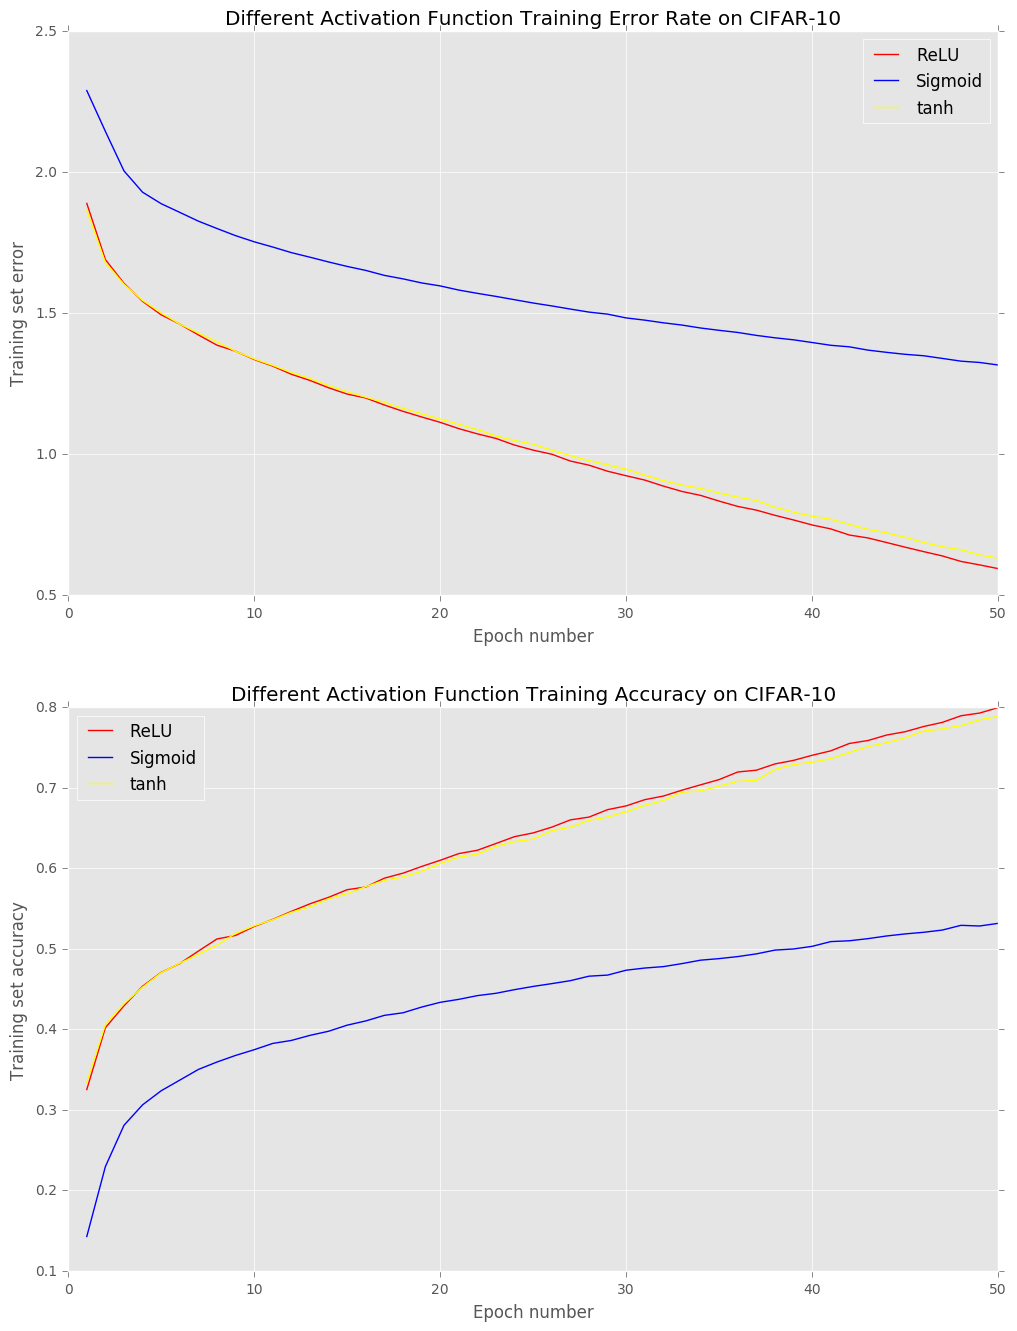

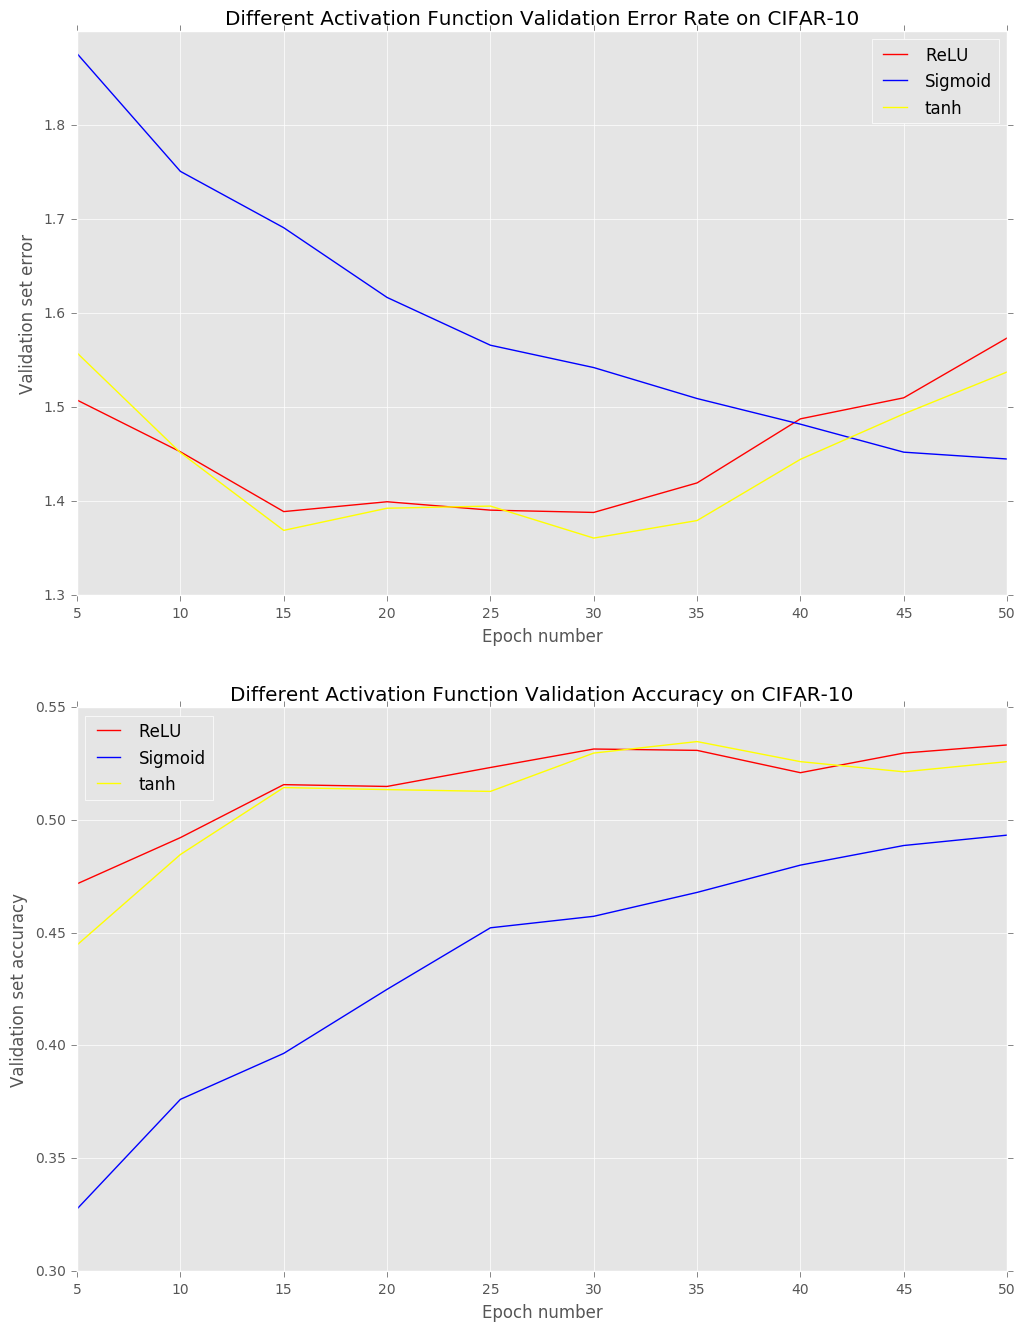

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

colorlist = ['#FF0000','#0000FF', '#FFFF00', '#000000', '#008000', '#800080', '#FFB6C1', '#FFA500']

fig1 = plt.figure(figsize=(12, 16))
ax1 = fig1.add_subplot(2, 1, 1)
ax2 = fig1.add_subplot(2, 1, 2)
ax1.plot(train_stats_ex1_1['epoch_num'], train_stats_ex1_1['error'], label='ReLU', color=colorlist[0])
ax1.plot(train_stats_ex1_2['epoch_num'], train_stats_ex1_2['error'], label='Sigmoid', color=colorlist[1])
ax1.plot(train_stats_ex1_3['epoch_num'], train_stats_ex1_3['error'], label='tanh', color=colorlist[2])

ax2.plot(train_stats_ex1_1['epoch_num'], train_stats_ex1_1['acc'], label='ReLU', color=colorlist[0])
ax2.plot(train_stats_ex1_2['epoch_num'], train_stats_ex1_2['acc'], label='Sigmoid', color=colorlist[1])
ax2.plot(train_stats_ex1_3['epoch_num'], train_stats_ex1_3['acc'], label='tanh', color=colorlist[2])

ax1.set_title('Different Activation Function Training Error Rate on CIFAR-10')
ax1.legend(loc='best')
ax1.set_xlabel('Epoch number')
ax1.set_ylabel('Training set error')

ax2.set_title('Different Activation Function Training Accuracy on CIFAR-10')
ax2.legend(loc='best')
ax2.set_xlabel('Epoch number')
ax2.set_ylabel('Training set accuracy')

plt.show()
fig1.tight_layout()
fig1.savefig('ex_1_fig_1.pdf')

fig2 = plt.figure(figsize=(12, 16))
ax1 = fig2.add_subplot(2, 1, 1)
ax2 = fig2.add_subplot(2, 1, 2)
ax1.plot(valid_stats_ex1_1['epoch_num'], valid_stats_ex1_1['error'], label='ReLU', color=colorlist[0])
ax1.plot(valid_stats_ex1_2['epoch_num'], valid_stats_ex1_2['error'], label='Sigmoid', color=colorlist[1])
ax1.plot(valid_stats_ex1_3['epoch_num'], valid_stats_ex1_3['error'], label='tanh', color=colorlist[2])

ax2.plot(valid_stats_ex1_1['epoch_num'], valid_stats_ex1_1['acc'], label='ReLU', color=colorlist[0])
ax2.plot(valid_stats_ex1_2['epoch_num'], valid_stats_ex1_2['acc'], label='Sigmoid', color=colorlist[1])
ax2.plot(valid_stats_ex1_3['epoch_num'], valid_stats_ex1_3['acc'], label='tanh', color=colorlist[2])

ax1.set_title('Different Activation Function Validation Error Rate on CIFAR-10')
ax1.legend(loc='best')
ax1.set_xlabel('Epoch number')
ax1.set_ylabel('Validation set error')

ax2.set_title('Different Activation Function Validation Accuracy on CIFAR-10')
ax2.legend(loc='best')
ax2.set_xlabel('Epoch number')
ax2.set_ylabel('Validation set accuracy')

plt.show()
fig2.tight_layout()
fig2.savefig('ex_1_fig_2.pdf')

### Experiment 2:  Exploring different hidden layer depths and widths

In [10]:
seed = 24102016 
rng = np.random.RandomState(seed)
train_data = CIFAR10DataProvider('train', batch_size=50, rng=rng)
valid_data = CIFAR10DataProvider('valid', batch_size=50, rng=rng)

#### 2-1. Using  1 hidden layer and 300 units per layer on CIFAR-10

In [11]:
def fully_connected_layer(inputs, input_dim, output_dim, nonlinearity=tf.nn.relu):
    weights = tf.Variable(
        tf.truncated_normal(
            [input_dim, output_dim], stddev=2. / (input_dim + output_dim)**0.5), 
        'weights')
    biases = tf.Variable(tf.zeros([output_dim]), 'biases')
    outputs = nonlinearity(tf.matmul(inputs, weights) + biases)
    return outputs

train_data.reset()
valid_data.reset()
tf.reset_default_graph()

inputs = tf.placeholder(tf.float32, [None, train_data.inputs.shape[1]], 'inputs')
targets = tf.placeholder(tf.float32, [None, train_data.num_classes], 'targets')
#note
num_hidden = 300

#note
with tf.name_scope('fc-layer-1'):
    hidden_1 = fully_connected_layer(inputs, train_data.inputs.shape[1], num_hidden)
with tf.name_scope('output-layer'):
    outputs = fully_connected_layer(hidden_1, num_hidden, train_data.num_classes, tf.identity)

with tf.name_scope('error'):
    error = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(outputs, targets))
with tf.name_scope('accuracy'):
    accuracy = tf.reduce_mean(tf.cast(
            tf.equal(tf.argmax(outputs, 1), tf.argmax(targets, 1)), 
            tf.float32))
#note
with tf.name_scope('train'):
    train_step = tf.train.AdamOptimizer(learning_rate = 0.0001, epsilon = 0.001).minimize(error)
    
init = tf.global_variables_initializer()

In [12]:
#note
train_stats_ex2_1 = {'epoch_num':[], 'error':[], 'acc':[], 'runningtime':[]}
valid_stats_ex2_1 = {'epoch_num':[], 'error':[], 'acc':[], 'runningtime':[]}
with tf.Session() as sess:
    sess.run(init)
    valid_time = 0.
    #note
    for e in range(50):
        start_time = time.time()
        if valid_time == 0.:
            valid_time = time.time()
        running_error = 0.
        running_accuracy = 0.
        for input_batch, target_batch in train_data:
            _, batch_error, batch_acc = sess.run(
                [train_step, error, accuracy], 
                feed_dict={inputs: input_batch, targets: target_batch})
            running_error += batch_error
            running_accuracy += batch_acc
        running_error /= train_data.num_batches
        running_accuracy /= train_data.num_batches
        epoch_time = time.time() - start_time
        #note
        train_stats_ex2_1['runningtime'].append(epoch_time)
        print('Epoch {0:02d}: {1:.2f}s to complete'.format(e + 1, epoch_time))
        print('End of epoch {0:02d}: err(train)={1:.2f} acc(train)={2:.2f}'
              .format(e + 1, running_error, running_accuracy))
        train_stats_ex2_1['epoch_num'].append(e + 1)
        train_stats_ex2_1['error'].append(running_error)
        train_stats_ex2_1['acc'].append(running_accuracy)
        if (e + 1) % 5 == 0:
            valid_error = 0.
            valid_accuracy = 0.
            for input_batch, target_batch in valid_data:
                batch_error, batch_acc = sess.run(
                    [error, accuracy], 
                    feed_dict={inputs: input_batch, targets: target_batch})
                valid_error += batch_error
                valid_accuracy += batch_acc
            valid_error /= valid_data.num_batches
            valid_accuracy /= valid_data.num_batches
            valid_time = time.time() - valid_time
            print('                 err(valid)={0:.2f} acc(valid)={1:.2f}'
                   .format(valid_error, valid_accuracy))
            #note
            valid_stats_ex2_1['epoch_num'].append(e + 1)
            valid_stats_ex2_1['error'].append(valid_error)
            valid_stats_ex2_1['acc'].append(valid_accuracy)
            valid_stats_ex2_1['runningtime'].append(valid_time)
            valid_time = 0.

Epoch 01: 10.12s to complete
End of epoch 01: err(train)=1.92 acc(train)=0.32
Epoch 02: 10.47s to complete
End of epoch 02: err(train)=1.74 acc(train)=0.39
Epoch 03: 10.23s to complete
End of epoch 03: err(train)=1.67 acc(train)=0.41
Epoch 04: 9.96s to complete
End of epoch 04: err(train)=1.61 acc(train)=0.43
Epoch 05: 9.74s to complete
End of epoch 05: err(train)=1.57 acc(train)=0.45
                 err(valid)=1.59 acc(valid)=0.44
Epoch 06: 9.98s to complete
End of epoch 06: err(train)=1.54 acc(train)=0.46
Epoch 07: 9.82s to complete
End of epoch 07: err(train)=1.51 acc(train)=0.47
Epoch 08: 10.06s to complete
End of epoch 08: err(train)=1.48 acc(train)=0.48
Epoch 09: 9.88s to complete
End of epoch 09: err(train)=1.46 acc(train)=0.49
Epoch 10: 9.72s to complete
End of epoch 10: err(train)=1.44 acc(train)=0.50
                 err(valid)=1.51 acc(valid)=0.48
Epoch 11: 9.75s to complete
End of epoch 11: err(train)=1.42 acc(train)=0.51
Epoch 12: 10.27s to complete
End of epoch 12: err(t

#### 2-2. Using  3 hidden layer and 300 units per layer on CIFAR-10

In [13]:
def fully_connected_layer(inputs, input_dim, output_dim, nonlinearity=tf.nn.relu):
    weights = tf.Variable(
        tf.truncated_normal(
            [input_dim, output_dim], stddev=2. / (input_dim + output_dim)**0.5), 
        'weights')
    biases = tf.Variable(tf.zeros([output_dim]), 'biases')
    outputs = nonlinearity(tf.matmul(inputs, weights) + biases)
    return outputs

train_data.reset()
valid_data.reset()
tf.reset_default_graph()

inputs = tf.placeholder(tf.float32, [None, train_data.inputs.shape[1]], 'inputs')
targets = tf.placeholder(tf.float32, [None, train_data.num_classes], 'targets')
#note
num_hidden = 300

#note
with tf.name_scope('fc-layer-1'):
    hidden_1 = fully_connected_layer(inputs, train_data.inputs.shape[1], num_hidden)
with tf.name_scope('fc-layer-2'):
    hidden_2 = fully_connected_layer(hidden_1, num_hidden, num_hidden)
with tf.name_scope('fc-layer-3'):
    hidden_3 = fully_connected_layer(hidden_2, num_hidden, num_hidden)
with tf.name_scope('output-layer'):
    outputs = fully_connected_layer(hidden_3, num_hidden, train_data.num_classes, tf.identity)

with tf.name_scope('error'):
    error = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(outputs, targets))
with tf.name_scope('accuracy'):
    accuracy = tf.reduce_mean(tf.cast(
            tf.equal(tf.argmax(outputs, 1), tf.argmax(targets, 1)), 
            tf.float32))
#note
with tf.name_scope('train'):
    train_step = tf.train.AdamOptimizer(learning_rate = 0.0001, epsilon = 0.001).minimize(error)
    
init = tf.global_variables_initializer()

In [14]:
#note
train_stats_ex2_2 = {'epoch_num':[], 'error':[], 'acc':[], 'runningtime':[]}
valid_stats_ex2_2 = {'epoch_num':[], 'error':[], 'acc':[], 'runningtime':[]}
with tf.Session() as sess:
    sess.run(init)
    valid_time = 0.
    #note
    for e in range(50):
        start_time = time.time()
        if valid_time == 0.:
            valid_time = time.time()
        running_error = 0.
        running_accuracy = 0.
        for input_batch, target_batch in train_data:
            _, batch_error, batch_acc = sess.run(
                [train_step, error, accuracy], 
                feed_dict={inputs: input_batch, targets: target_batch})
            running_error += batch_error
            running_accuracy += batch_acc
        running_error /= train_data.num_batches
        running_accuracy /= train_data.num_batches
        epoch_time = time.time() - start_time
        #note
        train_stats_ex2_2['runningtime'].append(epoch_time)
        print('Epoch {0:02d}: {1:.2f}s to complete'.format(e + 1, epoch_time))
        print('End of epoch {0:02d}: err(train)={1:.2f} acc(train)={2:.2f}'
              .format(e + 1, running_error, running_accuracy))
        train_stats_ex2_2['epoch_num'].append(e + 1)
        train_stats_ex2_2['error'].append(running_error)
        train_stats_ex2_2['acc'].append(running_accuracy)
        if (e + 1) % 5 == 0:
            valid_error = 0.
            valid_accuracy = 0.
            for input_batch, target_batch in valid_data:
                batch_error, batch_acc = sess.run(
                    [error, accuracy], 
                    feed_dict={inputs: input_batch, targets: target_batch})
                valid_error += batch_error
                valid_accuracy += batch_acc
            valid_error /= valid_data.num_batches
            valid_accuracy /= valid_data.num_batches
            valid_time = time.time() - valid_time
            print('                 err(valid)={0:.2f} acc(valid)={1:.2f}'
                   .format(valid_error, valid_accuracy))
            #note
            valid_stats_ex2_2['epoch_num'].append(e + 1)
            valid_stats_ex2_2['error'].append(valid_error)
            valid_stats_ex2_2['acc'].append(valid_accuracy)
            valid_stats_ex2_2['runningtime'].append(valid_time)
            valid_time = 0.

Epoch 01: 11.88s to complete
End of epoch 01: err(train)=1.89 acc(train)=0.32
Epoch 02: 12.05s to complete
End of epoch 02: err(train)=1.69 acc(train)=0.40
Epoch 03: 11.84s to complete
End of epoch 03: err(train)=1.61 acc(train)=0.43
Epoch 04: 11.57s to complete
End of epoch 04: err(train)=1.55 acc(train)=0.45
Epoch 05: 11.79s to complete
End of epoch 05: err(train)=1.50 acc(train)=0.47
                 err(valid)=1.53 acc(valid)=0.46
Epoch 06: 12.40s to complete
End of epoch 06: err(train)=1.46 acc(train)=0.49
Epoch 07: 12.58s to complete
End of epoch 07: err(train)=1.42 acc(train)=0.50
Epoch 08: 11.83s to complete
End of epoch 08: err(train)=1.39 acc(train)=0.51
Epoch 09: 11.31s to complete
End of epoch 09: err(train)=1.35 acc(train)=0.52
Epoch 10: 11.32s to complete
End of epoch 10: err(train)=1.33 acc(train)=0.53
                 err(valid)=1.44 acc(valid)=0.49
Epoch 11: 12.42s to complete
End of epoch 11: err(train)=1.30 acc(train)=0.54
Epoch 12: 12.79s to complete
End of epoch 12

#### 2-3 Using  5 hidden layer and 300 units per layer on CIFAR-10

In [15]:
def fully_connected_layer(inputs, input_dim, output_dim, nonlinearity=tf.nn.relu):
    weights = tf.Variable(
        tf.truncated_normal(
            [input_dim, output_dim], stddev=2. / (input_dim + output_dim)**0.5), 
        'weights')
    biases = tf.Variable(tf.zeros([output_dim]), 'biases')
    outputs = nonlinearity(tf.matmul(inputs, weights) + biases)
    return outputs

train_data.reset()
valid_data.reset()
tf.reset_default_graph()

inputs = tf.placeholder(tf.float32, [None, train_data.inputs.shape[1]], 'inputs')
targets = tf.placeholder(tf.float32, [None, train_data.num_classes], 'targets')
#note
num_hidden = 300

#note
with tf.name_scope('fc-layer-1'):
    hidden_1 = fully_connected_layer(inputs, train_data.inputs.shape[1], num_hidden)
with tf.name_scope('fc-layer-2'):
    hidden_2 = fully_connected_layer(hidden_1, num_hidden, num_hidden)
with tf.name_scope('fc-layer-3'):
    hidden_3 = fully_connected_layer(hidden_2, num_hidden, num_hidden)
with tf.name_scope('fc-layer-4'):
    hidden_4 = fully_connected_layer(hidden_3, num_hidden, num_hidden)
with tf.name_scope('fc-layer-5'):
    hidden_5 = fully_connected_layer(hidden_4, num_hidden, num_hidden)
with tf.name_scope('output-layer'):
    outputs = fully_connected_layer(hidden_5, num_hidden, train_data.num_classes, tf.identity)

with tf.name_scope('error'):
    error = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(outputs, targets))
with tf.name_scope('accuracy'):
    accuracy = tf.reduce_mean(tf.cast(
            tf.equal(tf.argmax(outputs, 1), tf.argmax(targets, 1)), 
            tf.float32))
#note
with tf.name_scope('train'):
    train_step = tf.train.AdamOptimizer(learning_rate = 0.0001, epsilon = 0.001).minimize(error)
    
init = tf.global_variables_initializer()

In [16]:
#note
train_stats_ex2_3 = {'epoch_num':[], 'error':[], 'acc':[], 'runningtime':[]}
valid_stats_ex2_3 = {'epoch_num':[], 'error':[], 'acc':[], 'runningtime':[]}
with tf.Session() as sess:
    sess.run(init)
    valid_time = 0.
    #note
    for e in range(50):
        start_time = time.time()
        if valid_time == 0.:
            valid_time = time.time()
        running_error = 0.
        running_accuracy = 0.
        for input_batch, target_batch in train_data:
            _, batch_error, batch_acc = sess.run(
                [train_step, error, accuracy], 
                feed_dict={inputs: input_batch, targets: target_batch})
            running_error += batch_error
            running_accuracy += batch_acc
        running_error /= train_data.num_batches
        running_accuracy /= train_data.num_batches
        epoch_time = time.time() - start_time
        #note
        train_stats_ex2_3['runningtime'].append(epoch_time)
        print('Epoch {0:02d}: {1:.2f}s to complete'.format(e + 1, epoch_time))
        print('End of epoch {0:02d}: err(train)={1:.2f} acc(train)={2:.2f}'
              .format(e + 1, running_error, running_accuracy))
        train_stats_ex2_3['epoch_num'].append(e + 1)
        train_stats_ex2_3['error'].append(running_error)
        train_stats_ex2_3['acc'].append(running_accuracy)
        if (e + 1) % 5 == 0:
            valid_error = 0.
            valid_accuracy = 0.
            for input_batch, target_batch in valid_data:
                batch_error, batch_acc = sess.run(
                    [error, accuracy], 
                    feed_dict={inputs: input_batch, targets: target_batch})
                valid_error += batch_error
                valid_accuracy += batch_acc
            valid_error /= valid_data.num_batches
            valid_accuracy /= valid_data.num_batches
            valid_time = time.time() - valid_time
            print('                 err(valid)={0:.2f} acc(valid)={1:.2f}'
                   .format(valid_error, valid_accuracy))
            #note
            valid_stats_ex2_3['epoch_num'].append(e + 1)
            valid_stats_ex2_3['error'].append(valid_error)
            valid_stats_ex2_3['acc'].append(valid_accuracy)
            valid_stats_ex2_3['runningtime'].append(valid_time)
            valid_time = 0.

Epoch 01: 13.51s to complete
End of epoch 01: err(train)=1.88 acc(train)=0.32
Epoch 02: 14.00s to complete
End of epoch 02: err(train)=1.67 acc(train)=0.41
Epoch 03: 13.93s to complete
End of epoch 03: err(train)=1.59 acc(train)=0.43
Epoch 04: 14.08s to complete
End of epoch 04: err(train)=1.53 acc(train)=0.46
Epoch 05: 14.15s to complete
End of epoch 05: err(train)=1.48 acc(train)=0.48
                 err(valid)=1.51 acc(valid)=0.46
Epoch 06: 13.70s to complete
End of epoch 06: err(train)=1.44 acc(train)=0.49
Epoch 07: 14.57s to complete
End of epoch 07: err(train)=1.41 acc(train)=0.50
Epoch 08: 14.38s to complete
End of epoch 08: err(train)=1.37 acc(train)=0.51
Epoch 09: 14.16s to complete
End of epoch 09: err(train)=1.34 acc(train)=0.53
Epoch 10: 14.12s to complete
End of epoch 10: err(train)=1.31 acc(train)=0.54
                 err(valid)=1.44 acc(valid)=0.49
Epoch 11: 13.87s to complete
End of epoch 11: err(train)=1.28 acc(train)=0.55
Epoch 12: 13.24s to complete
End of epoch 12

#### 2-4. Using  3 hidden layer and 500 units per layer on CIFAR-10

In [17]:
def fully_connected_layer(inputs, input_dim, output_dim, nonlinearity=tf.nn.relu):
    weights = tf.Variable(
        tf.truncated_normal(
            [input_dim, output_dim], stddev=2. / (input_dim + output_dim)**0.5), 
        'weights')
    biases = tf.Variable(tf.zeros([output_dim]), 'biases')
    outputs = nonlinearity(tf.matmul(inputs, weights) + biases)
    return outputs

train_data.reset()
valid_data.reset()
tf.reset_default_graph()

inputs = tf.placeholder(tf.float32, [None, train_data.inputs.shape[1]], 'inputs')
targets = tf.placeholder(tf.float32, [None, train_data.num_classes], 'targets')
#note
num_hidden = 500

#note
with tf.name_scope('fc-layer-1'):
    hidden_1 = fully_connected_layer(inputs, train_data.inputs.shape[1], num_hidden)
with tf.name_scope('fc-layer-2'):
    hidden_2 = fully_connected_layer(hidden_1, num_hidden, num_hidden)
with tf.name_scope('fc-layer-3'):
    hidden_3 = fully_connected_layer(hidden_2, num_hidden, num_hidden)
with tf.name_scope('output-layer'):
    outputs = fully_connected_layer(hidden_3, num_hidden, train_data.num_classes, tf.identity)

with tf.name_scope('error'):
    error = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(outputs, targets))
with tf.name_scope('accuracy'):
    accuracy = tf.reduce_mean(tf.cast(
            tf.equal(tf.argmax(outputs, 1), tf.argmax(targets, 1)), 
            tf.float32))
#note
with tf.name_scope('train'):
    train_step = tf.train.AdamOptimizer(learning_rate = 0.0001, epsilon = 0.001).minimize(error)
    
init = tf.global_variables_initializer()

In [18]:
#note
train_stats_ex2_4 = {'epoch_num':[], 'error':[], 'acc':[], 'runningtime':[]}
valid_stats_ex2_4 = {'epoch_num':[], 'error':[], 'acc':[], 'runningtime':[]}
with tf.Session() as sess:
    sess.run(init)
    valid_time = 0.
    #note
    for e in range(50):
        start_time = time.time()
        if valid_time == 0.:
            valid_time = time.time()
        running_error = 0.
        running_accuracy = 0.
        for input_batch, target_batch in train_data:
            _, batch_error, batch_acc = sess.run(
                [train_step, error, accuracy], 
                feed_dict={inputs: input_batch, targets: target_batch})
            running_error += batch_error
            running_accuracy += batch_acc
        running_error /= train_data.num_batches
        running_accuracy /= train_data.num_batches
        epoch_time = time.time() - start_time
        #note
        train_stats_ex2_4['runningtime'].append(epoch_time)
        print('Epoch {0:02d}: {1:.2f}s to complete'.format(e + 1, epoch_time))
        print('End of epoch {0:02d}: err(train)={1:.2f} acc(train)={2:.2f}'
              .format(e + 1, running_error, running_accuracy))
        train_stats_ex2_4['epoch_num'].append(e + 1)
        train_stats_ex2_4['error'].append(running_error)
        train_stats_ex2_4['acc'].append(running_accuracy)
        if (e + 1) % 5 == 0:
            valid_error = 0.
            valid_accuracy = 0.
            for input_batch, target_batch in valid_data:
                batch_error, batch_acc = sess.run(
                    [error, accuracy], 
                    feed_dict={inputs: input_batch, targets: target_batch})
                valid_error += batch_error
                valid_accuracy += batch_acc
            valid_error /= valid_data.num_batches
            valid_accuracy /= valid_data.num_batches
            valid_time = time.time() - valid_time
            print('                 err(valid)={0:.2f} acc(valid)={1:.2f}'
                   .format(valid_error, valid_accuracy))
            #note
            valid_stats_ex2_4['epoch_num'].append(e + 1)
            valid_stats_ex2_4['error'].append(valid_error)
            valid_stats_ex2_4['acc'].append(valid_accuracy)
            valid_stats_ex2_4['runningtime'].append(valid_time)
            valid_time = 0.

Epoch 01: 20.38s to complete
End of epoch 01: err(train)=1.86 acc(train)=0.34
Epoch 02: 20.10s to complete
End of epoch 02: err(train)=1.65 acc(train)=0.41
Epoch 03: 24.31s to complete
End of epoch 03: err(train)=1.57 acc(train)=0.44
Epoch 04: 26.14s to complete
End of epoch 04: err(train)=1.51 acc(train)=0.47
Epoch 05: 21.92s to complete
End of epoch 05: err(train)=1.46 acc(train)=0.48
                 err(valid)=1.50 acc(valid)=0.47
Epoch 06: 23.32s to complete
End of epoch 06: err(train)=1.42 acc(train)=0.50
Epoch 07: 20.48s to complete
End of epoch 07: err(train)=1.37 acc(train)=0.51
Epoch 08: 20.10s to complete
End of epoch 08: err(train)=1.34 acc(train)=0.53
Epoch 09: 20.12s to complete
End of epoch 09: err(train)=1.30 acc(train)=0.54
Epoch 10: 20.10s to complete
End of epoch 10: err(train)=1.27 acc(train)=0.55
                 err(valid)=1.42 acc(valid)=0.50
Epoch 11: 20.13s to complete
End of epoch 11: err(train)=1.24 acc(train)=0.56
Epoch 12: 20.10s to complete
End of epoch 12

#### 2-5. Using  3 hidden layer and 1000 units per layer on CIFAR-10

In [19]:
def fully_connected_layer(inputs, input_dim, output_dim, nonlinearity=tf.nn.relu):
    weights = tf.Variable(
        tf.truncated_normal(
            [input_dim, output_dim], stddev=2. / (input_dim + output_dim)**0.5), 
        'weights')
    biases = tf.Variable(tf.zeros([output_dim]), 'biases')
    outputs = nonlinearity(tf.matmul(inputs, weights) + biases)
    return outputs

train_data.reset()
valid_data.reset()
tf.reset_default_graph()

inputs = tf.placeholder(tf.float32, [None, train_data.inputs.shape[1]], 'inputs')
targets = tf.placeholder(tf.float32, [None, train_data.num_classes], 'targets')
#note
num_hidden = 1000

#note
with tf.name_scope('fc-layer-1'):
    hidden_1 = fully_connected_layer(inputs, train_data.inputs.shape[1], num_hidden)
with tf.name_scope('fc-layer-2'):
    hidden_2 = fully_connected_layer(hidden_1, num_hidden, num_hidden)
with tf.name_scope('fc-layer-3'):
    hidden_3 = fully_connected_layer(hidden_2, num_hidden, num_hidden)
with tf.name_scope('output-layer'):
    outputs = fully_connected_layer(hidden_3, num_hidden, train_data.num_classes, tf.identity)

with tf.name_scope('error'):
    error = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(outputs, targets))
with tf.name_scope('accuracy'):
    accuracy = tf.reduce_mean(tf.cast(
            tf.equal(tf.argmax(outputs, 1), tf.argmax(targets, 1)), 
            tf.float32))
#note
with tf.name_scope('train'):
    train_step = tf.train.AdamOptimizer(learning_rate = 0.0001, epsilon = 0.001).minimize(error)
    
init = tf.global_variables_initializer()

In [20]:
#note
train_stats_ex2_5 = {'epoch_num':[], 'error':[], 'acc':[], 'runningtime':[]}
valid_stats_ex2_5 = {'epoch_num':[], 'error':[], 'acc':[], 'runningtime':[]}
with tf.Session() as sess:
    sess.run(init)
    valid_time = 0.
    #note
    for e in range(50):
        start_time = time.time()
        if valid_time == 0.:
            valid_time = time.time()
        running_error = 0.
        running_accuracy = 0.
        for input_batch, target_batch in train_data:
            _, batch_error, batch_acc = sess.run(
                [train_step, error, accuracy], 
                feed_dict={inputs: input_batch, targets: target_batch})
            running_error += batch_error
            running_accuracy += batch_acc
        running_error /= train_data.num_batches
        running_accuracy /= train_data.num_batches
        epoch_time = time.time() - start_time
        #note
        train_stats_ex2_3['runningtime'].append(epoch_time)
        print('Epoch {0:02d}: {1:.2f}s to complete'.format(e + 1, epoch_time))
        print('End of epoch {0:02d}: err(train)={1:.2f} acc(train)={2:.2f}'
              .format(e + 1, running_error, running_accuracy))
        train_stats_ex2_5['epoch_num'].append(e + 1)
        train_stats_ex2_5['error'].append(running_error)
        train_stats_ex2_5['acc'].append(running_accuracy)
        if (e + 1) % 5 == 0:
            valid_error = 0.
            valid_accuracy = 0.
            for input_batch, target_batch in valid_data:
                batch_error, batch_acc = sess.run(
                    [error, accuracy], 
                    feed_dict={inputs: input_batch, targets: target_batch})
                valid_error += batch_error
                valid_accuracy += batch_acc
            valid_error /= valid_data.num_batches
            valid_accuracy /= valid_data.num_batches
            valid_time = time.time() - valid_time
            print('                 err(valid)={0:.2f} acc(valid)={1:.2f}'
                   .format(valid_error, valid_accuracy))
            #note
            valid_stats_ex2_5['epoch_num'].append(e + 1)
            valid_stats_ex2_5['error'].append(valid_error)
            valid_stats_ex2_5['acc'].append(valid_accuracy)
            valid_stats_ex2_5['runningtime'].append(valid_time)
            valid_time = 0.

Epoch 01: 46.48s to complete
End of epoch 01: err(train)=1.82 acc(train)=0.35
Epoch 02: 46.01s to complete
End of epoch 02: err(train)=1.62 acc(train)=0.42
Epoch 03: 46.14s to complete
End of epoch 03: err(train)=1.53 acc(train)=0.46
Epoch 04: 48.75s to complete
End of epoch 04: err(train)=1.46 acc(train)=0.48
Epoch 05: 47.59s to complete
End of epoch 05: err(train)=1.41 acc(train)=0.50
                 err(valid)=1.47 acc(valid)=0.48
Epoch 06: 49.68s to complete
End of epoch 06: err(train)=1.36 acc(train)=0.52
Epoch 07: 50.50s to complete
End of epoch 07: err(train)=1.31 acc(train)=0.53
Epoch 08: 48.81s to complete
End of epoch 08: err(train)=1.27 acc(train)=0.55
Epoch 09: 50.06s to complete
End of epoch 09: err(train)=1.22 acc(train)=0.57
Epoch 10: 48.57s to complete
End of epoch 10: err(train)=1.19 acc(train)=0.58
                 err(valid)=1.39 acc(valid)=0.52
Epoch 11: 49.67s to complete
End of epoch 11: err(train)=1.14 acc(train)=0.60
Epoch 12: 49.56s to complete
End of epoch 12

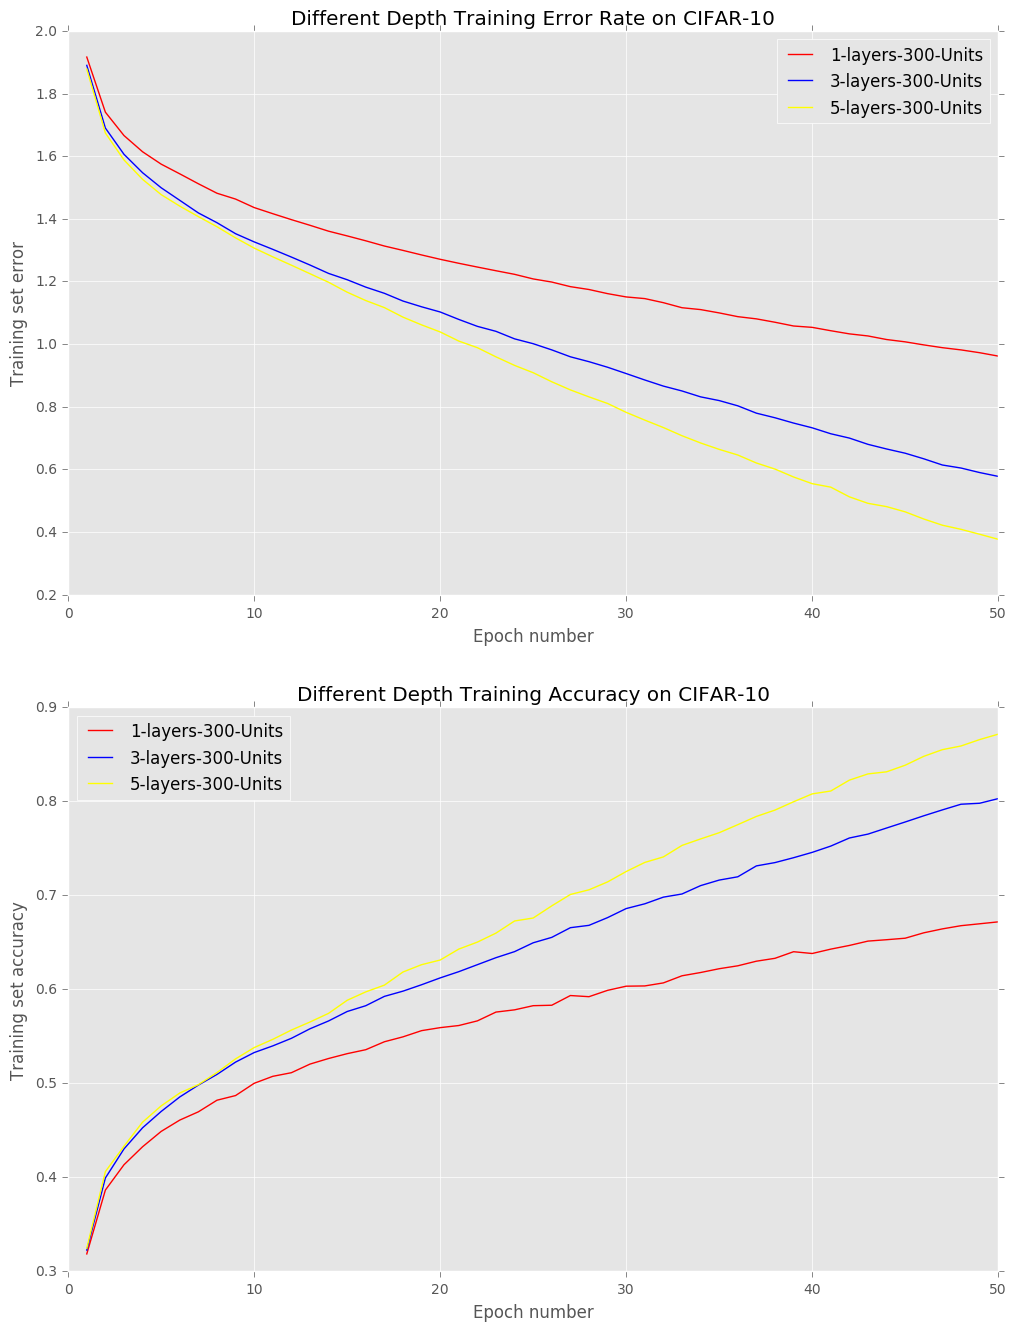

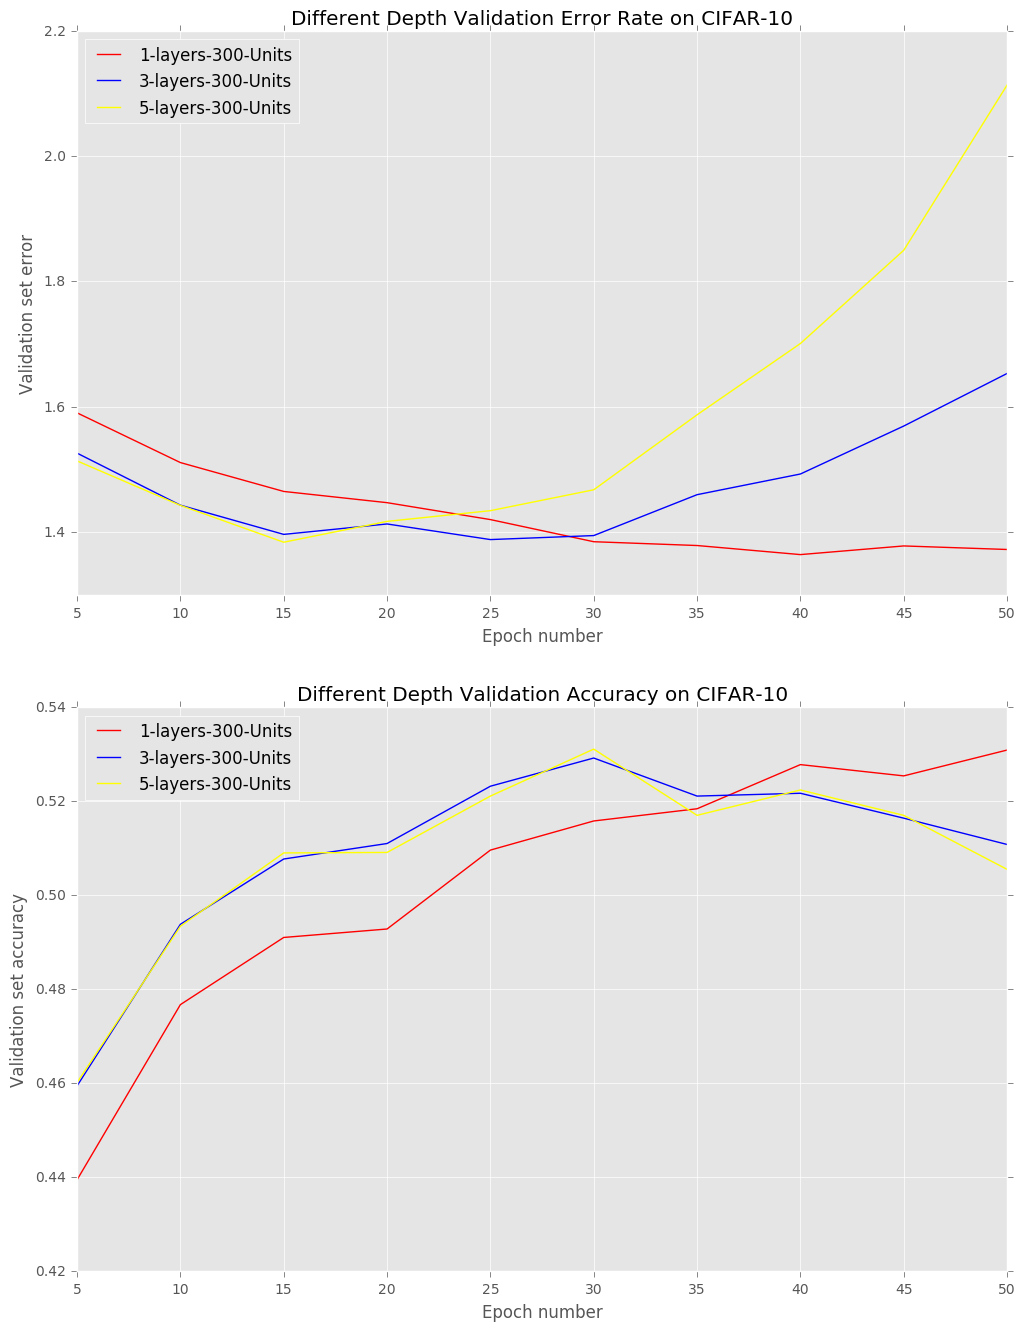

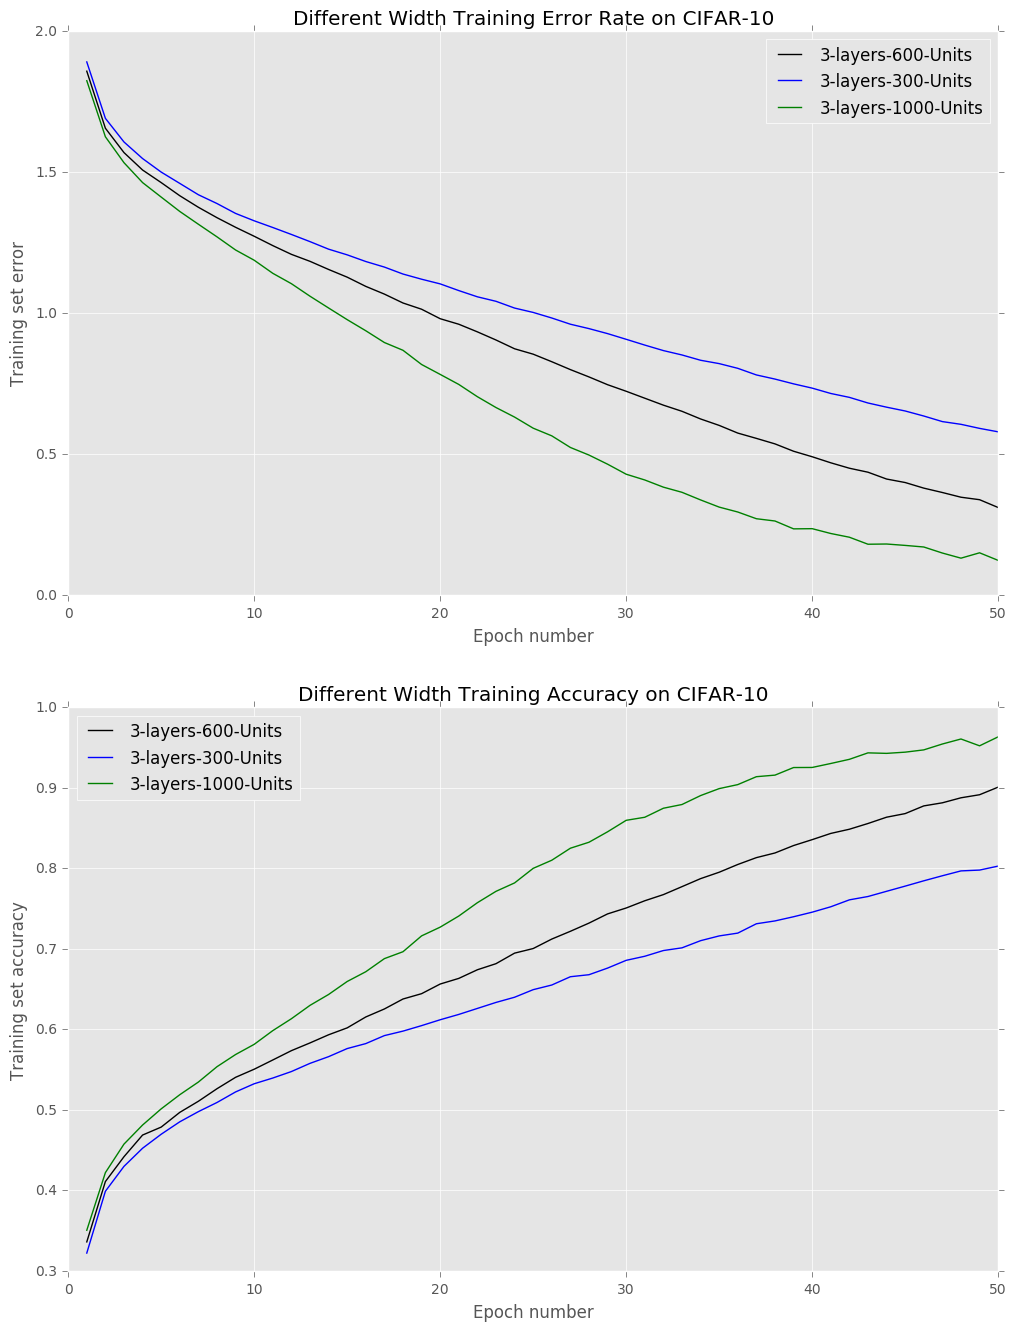

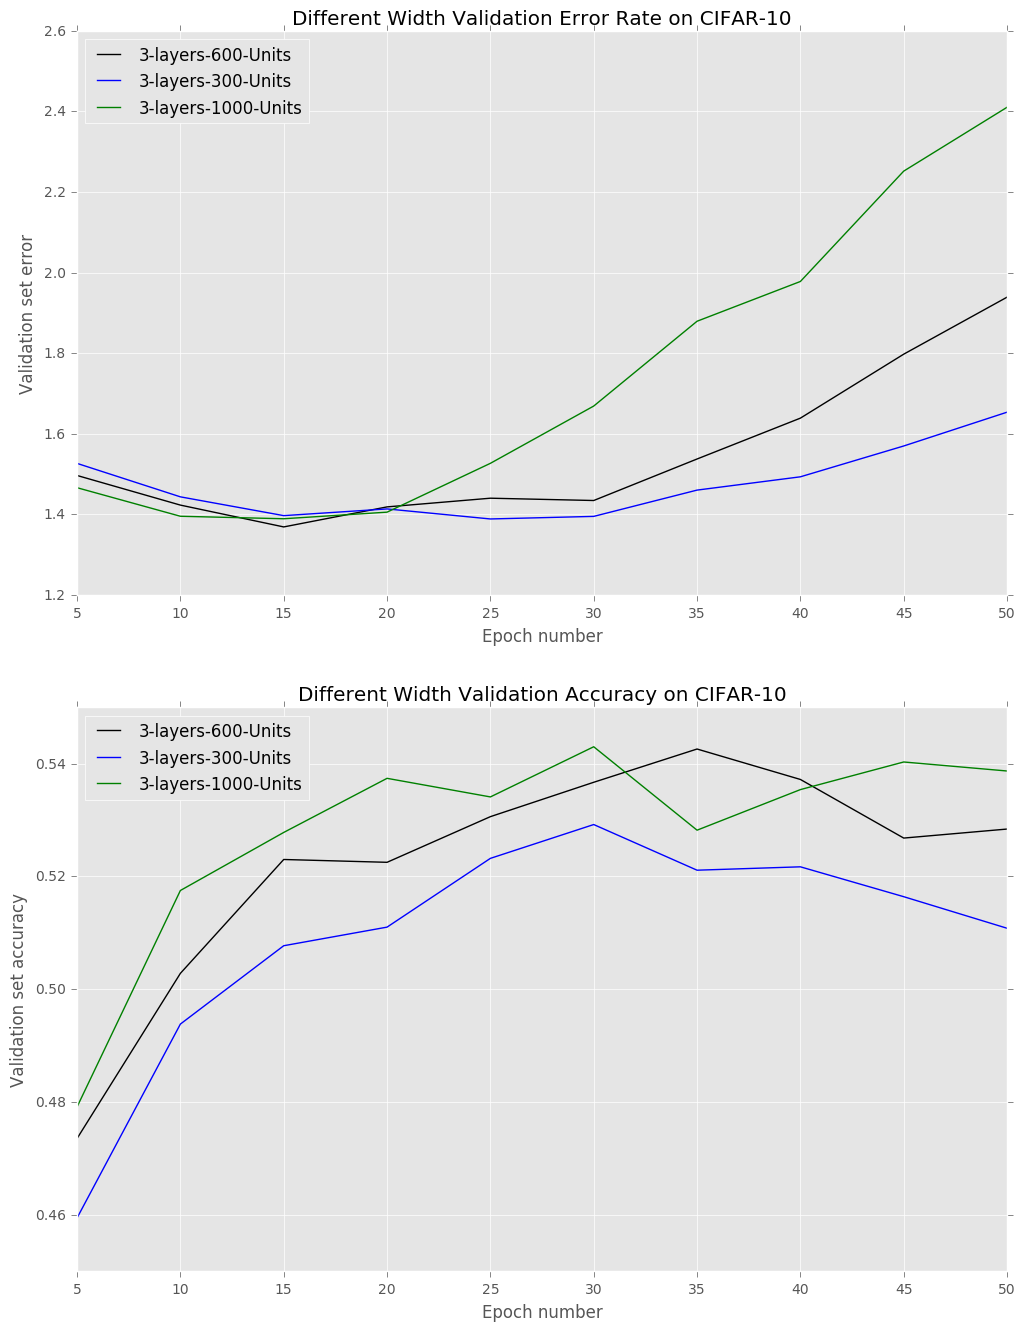

In [27]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

colorlist = ['#FF0000','#0000FF', '#FFFF00', '#000000', '#008000', '#800080', '#FFB6C1', '#FFA500']

fig1 = plt.figure(figsize=(12, 16))
ax1 = fig1.add_subplot(2, 1, 1)
ax2 = fig1.add_subplot(2, 1, 2)
ax1.plot(train_stats_ex2_1['epoch_num'], train_stats_ex2_1['error'], label='1-layers-300-Units', color=colorlist[0])
ax1.plot(train_stats_ex2_2['epoch_num'], train_stats_ex2_2['error'], label='3-layers-300-Units', color=colorlist[1])
ax1.plot(train_stats_ex2_3['epoch_num'], train_stats_ex2_3['error'], label='5-layers-300-Units', color=colorlist[2])

ax2.plot(train_stats_ex2_1['epoch_num'], train_stats_ex2_1['acc'], label='1-layers-300-Units', color=colorlist[0])
ax2.plot(train_stats_ex2_2['epoch_num'], train_stats_ex2_2['acc'], label='3-layers-300-Units', color=colorlist[1])
ax2.plot(train_stats_ex2_3['epoch_num'], train_stats_ex2_3['acc'], label='5-layers-300-Units', color=colorlist[2])

ax1.set_title('Different Depth Training Error Rate on CIFAR-10')
ax1.legend(loc='best')
ax1.set_xlabel('Epoch number')
ax1.set_ylabel('Training set error')

ax2.set_title('Different Depth Training Accuracy on CIFAR-10')
ax2.legend(loc='best')
ax2.set_xlabel('Epoch number')
ax2.set_ylabel('Training set accuracy')

plt.show()
fig1.tight_layout()
fig1.savefig('ex_2_fig_1.pdf')

fig2 = plt.figure(figsize=(12, 16))
ax1 = fig2.add_subplot(2, 1, 1)
ax2 = fig2.add_subplot(2, 1, 2)
ax1.plot(valid_stats_ex2_1['epoch_num'], valid_stats_ex2_1['error'], label='1-layers-300-Units', color=colorlist[0])
ax1.plot(valid_stats_ex2_2['epoch_num'], valid_stats_ex2_2['error'], label='3-layers-300-Units', color=colorlist[1])
ax1.plot(valid_stats_ex2_3['epoch_num'], valid_stats_ex2_3['error'], label='5-layers-300-Units', color=colorlist[2])

ax2.plot(valid_stats_ex2_1['epoch_num'], valid_stats_ex2_1['acc'], label='1-layers-300-Units', color=colorlist[0])
ax2.plot(valid_stats_ex2_2['epoch_num'], valid_stats_ex2_2['acc'], label='3-layers-300-Units', color=colorlist[1])
ax2.plot(valid_stats_ex2_3['epoch_num'], valid_stats_ex2_3['acc'], label='5-layers-300-Units', color=colorlist[2])

ax1.set_title('Different Depth Validation Error Rate on CIFAR-10')
ax1.legend(loc='best')
ax1.set_xlabel('Epoch number')
ax1.set_ylabel('Validation set error')

ax2.set_title('Different Depth Validation Accuracy on CIFAR-10')
ax2.legend(loc='best')
ax2.set_xlabel('Epoch number')
ax2.set_ylabel('Validation set accuracy')

plt.show()
fig2.tight_layout()
fig2.savefig('ex_2_fig_2.pdf')


fig3 = plt.figure(figsize=(12, 16))
ax1 = fig3.add_subplot(2, 1, 1)
ax2 = fig3.add_subplot(2, 1, 2)
ax1.plot(train_stats_ex2_4['epoch_num'], train_stats_ex2_4['error'], label='3-layers-600-Units', color=colorlist[3])
ax1.plot(train_stats_ex2_2['epoch_num'], train_stats_ex2_2['error'], label='3-layers-300-Units', color=colorlist[1])
ax1.plot(train_stats_ex2_5['epoch_num'], train_stats_ex2_5['error'], label='3-layers-1000-Units', color=colorlist[4])

ax2.plot(train_stats_ex2_4['epoch_num'], train_stats_ex2_4['acc'], label='3-layers-600-Units', color=colorlist[3])
ax2.plot(train_stats_ex2_2['epoch_num'], train_stats_ex2_2['acc'], label='3-layers-300-Units', color=colorlist[1])
ax2.plot(train_stats_ex2_5['epoch_num'], train_stats_ex2_5['acc'], label='3-layers-1000-Units', color=colorlist[4])

ax1.set_title('Different Width Training Error Rate on CIFAR-10')
ax1.legend(loc='best')
ax1.set_xlabel('Epoch number')
ax1.set_ylabel('Training set error')

ax2.set_title('Different Width Training Accuracy on CIFAR-10')
ax2.legend(loc='best')
ax2.set_xlabel('Epoch number')
ax2.set_ylabel('Training set accuracy')

plt.show()
fig3.tight_layout()
fig3.savefig('ex_2_fig_3.pdf')

fig4 = plt.figure(figsize=(12, 16))
ax1 = fig4.add_subplot(2, 1, 1)
ax2 = fig4.add_subplot(2, 1, 2)
ax1.plot(valid_stats_ex2_4['epoch_num'], valid_stats_ex2_4['error'], label='3-layers-600-Units', color=colorlist[3])
ax1.plot(valid_stats_ex2_2['epoch_num'], valid_stats_ex2_2['error'], label='3-layers-300-Units', color=colorlist[1])
ax1.plot(valid_stats_ex2_5['epoch_num'], valid_stats_ex2_5['error'], label='3-layers-1000-Units', color=colorlist[4])

ax2.plot(valid_stats_ex2_4['epoch_num'], valid_stats_ex2_4['acc'], label='3-layers-600-Units', color=colorlist[3])
ax2.plot(valid_stats_ex2_2['epoch_num'], valid_stats_ex2_2['acc'], label='3-layers-300-Units', color=colorlist[1])
ax2.plot(valid_stats_ex2_5['epoch_num'], valid_stats_ex2_5['acc'], label='3-layers-1000-Units', color=colorlist[4])

ax1.set_title('Different Width Validation Error Rate on CIFAR-10')
ax1.legend(loc='best')
ax1.set_xlabel('Epoch number')
ax1.set_ylabel('Validation set error')

ax2.set_title('Different Width Validation Accuracy on CIFAR-10')
ax2.legend(loc='best')
ax2.set_xlabel('Epoch number')
ax2.set_ylabel('Validation set accuracy')

plt.show()
fig4.tight_layout()
fig4.savefig('ex_2_fig_4.pdf')

### Experiment 3:  Exploring different regularisation

In [3]:
seed = 24102016 
rng = np.random.RandomState(seed)
train_data = CIFAR10DataProvider('train', batch_size=50, rng=rng)
valid_data = CIFAR10DataProvider('valid', batch_size=50, rng=rng)

#### 3-1. Using  L1 regularisation on CIFAR-10

In [4]:
def fully_connected_layer(inputs, input_dim, output_dim, nonlinearity=tf.nn.relu):
    weights = tf.Variable(
        tf.truncated_normal(
            [input_dim, output_dim], stddev=2. / (input_dim + output_dim)**0.5), 
        'weights')
    biases = tf.Variable(tf.zeros([output_dim]), 'biases')
    outputs = nonlinearity(tf.matmul(inputs, weights) + biases)
    return outputs, weights

train_data.reset()
valid_data.reset()
tf.reset_default_graph()

inputs = tf.placeholder(tf.float32, [None, train_data.inputs.shape[1]], 'inputs')
targets = tf.placeholder(tf.float32, [None, train_data.num_classes], 'targets')
#note
num_hidden = 300
beta_l1 = 0.0001

#note
with tf.name_scope('fc-layer-1'):
    hidden_1, weight_1 = fully_connected_layer(inputs, train_data.inputs.shape[1], num_hidden)
with tf.name_scope('fc-layer-2'):
    hidden_2, weight_2 = fully_connected_layer(hidden_1, num_hidden, num_hidden)
with tf.name_scope('fc-layer-3'):
    hidden_3, weight_3 = fully_connected_layer(hidden_2, num_hidden, num_hidden)
with tf.name_scope('output-layer'):
    outputs, weight_4 = fully_connected_layer(hidden_3, num_hidden, train_data.num_classes, tf.identity)

with tf.name_scope('L1-regularisation'):
    l1_reg = (tf.reduce_sum(tf.abs(weight_1)) + tf.reduce_sum(tf.abs(weight_2))
              + tf.reduce_sum(tf.abs(weight_3)) + tf.reduce_sum(tf.abs(weight_4)))
with tf.name_scope('error'):
    error = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(outputs, targets)) + beta_l1 * l1_reg
with tf.name_scope('accuracy'):
    accuracy = tf.reduce_mean(tf.cast(
            tf.equal(tf.argmax(outputs, 1), tf.argmax(targets, 1)), 
            tf.float32))
#note
with tf.name_scope('train'):
    train_step = tf.train.AdamOptimizer(learning_rate = 0.0001, epsilon = 0.001).minimize(error)
    
init = tf.global_variables_initializer()

In [5]:
#note
train_stats_ex3_1 = {'epoch_num':[], 'error':[], 'acc':[], 'runningtime':[]}
valid_stats_ex3_1 = {'epoch_num':[], 'error':[], 'acc':[], 'runningtime':[]}
with tf.Session() as sess:
    sess.run(init)
    valid_time = 0.
    #note
    for e in range(100):
        start_time = time.time()
        if valid_time == 0.:
            valid_time = time.time()
        running_error = 0.
        running_accuracy = 0.
        for input_batch, target_batch in train_data:
            _, batch_error, batch_acc = sess.run(
                [train_step, error, accuracy], 
                feed_dict={inputs: input_batch, targets: target_batch})
            running_error += batch_error
            running_accuracy += batch_acc
        running_error /= train_data.num_batches
        running_accuracy /= train_data.num_batches
        epoch_time = time.time() - start_time
        #note
        train_stats_ex3_1['runningtime'].append(epoch_time)
        print('Epoch {0:02d}: {1:.2f}s to complete'.format(e + 1, epoch_time))
        print('End of epoch {0:02d}: err(train)={1:.2f} acc(train)={2:.2f}'
              .format(e + 1, running_error, running_accuracy))
        train_stats_ex3_1['epoch_num'].append(e + 1)
        train_stats_ex3_1['error'].append(running_error)
        train_stats_ex3_1['acc'].append(running_accuracy)
        if (e + 1) % 5 == 0:
            valid_error = 0.
            valid_accuracy = 0.
            for input_batch, target_batch in valid_data:
                batch_error, batch_acc = sess.run(
                    [error, accuracy], 
                    feed_dict={inputs: input_batch, targets: target_batch})
                valid_error += batch_error
                valid_accuracy += batch_acc
            valid_error /= valid_data.num_batches
            valid_accuracy /= valid_data.num_batches
            valid_time = time.time() - valid_time
            print('                 err(valid)={0:.2f} acc(valid)={1:.2f}'
                   .format(valid_error, valid_accuracy))
            #note
            valid_stats_ex3_1['epoch_num'].append(e + 1)
            valid_stats_ex3_1['error'].append(valid_error)
            valid_stats_ex3_1['acc'].append(valid_accuracy)
            valid_stats_ex3_1['runningtime'].append(valid_time)
            valid_time = 0.

Epoch 01: 31.75s to complete
End of epoch 01: err(train)=5.18 acc(train)=0.32
Epoch 02: 41.41s to complete
End of epoch 02: err(train)=4.74 acc(train)=0.40
Epoch 03: 41.08s to complete
End of epoch 03: err(train)=4.41 acc(train)=0.43
Epoch 04: 35.73s to complete
End of epoch 04: err(train)=4.12 acc(train)=0.45
Epoch 05: 32.63s to complete
End of epoch 05: err(train)=3.87 acc(train)=0.46
                 err(valid)=3.79 acc(valid)=0.46
Epoch 06: 31.45s to complete
End of epoch 06: err(train)=3.66 acc(train)=0.47
Epoch 07: 31.14s to complete
End of epoch 07: err(train)=3.48 acc(train)=0.48
Epoch 08: 31.61s to complete
End of epoch 08: err(train)=3.32 acc(train)=0.50
Epoch 09: 31.57s to complete
End of epoch 09: err(train)=3.19 acc(train)=0.50
Epoch 10: 31.19s to complete
End of epoch 10: err(train)=3.06 acc(train)=0.51
                 err(valid)=3.12 acc(valid)=0.47
Epoch 11: 31.41s to complete
End of epoch 11: err(train)=2.96 acc(train)=0.51
Epoch 12: 30.92s to complete
End of epoch 12

#### 3-2. Using  L2 regularisation on CIFAR-10

In [6]:
def fully_connected_layer(inputs, input_dim, output_dim, nonlinearity=tf.nn.relu):
    weights = tf.Variable(
        tf.truncated_normal(
            [input_dim, output_dim], stddev=2. / (input_dim + output_dim)**0.5), 
        'weights')
    biases = tf.Variable(tf.zeros([output_dim]), 'biases')
    outputs = nonlinearity(tf.matmul(inputs, weights) + biases)
    return outputs, weights

train_data.reset()
valid_data.reset()
tf.reset_default_graph()

inputs = tf.placeholder(tf.float32, [None, train_data.inputs.shape[1]], 'inputs')
targets = tf.placeholder(tf.float32, [None, train_data.num_classes], 'targets')
#note
num_hidden = 300
beta_l2 = 0.01

#note
with tf.name_scope('fc-layer-1'):
    hidden_1, weight_1 = fully_connected_layer(inputs, train_data.inputs.shape[1], num_hidden)
with tf.name_scope('fc-layer-2'):
    hidden_2, weight_2 = fully_connected_layer(hidden_1, num_hidden, num_hidden)
with tf.name_scope('fc-layer-3'):
    hidden_3, weight_3 = fully_connected_layer(hidden_2, num_hidden, num_hidden)
with tf.name_scope('output-layer'):
    outputs, weight_4 = fully_connected_layer(hidden_3, num_hidden, train_data.num_classes, tf.identity)

with tf.name_scope('L2-regularisation'):
    l2_reg = tf.nn.l2_loss(weight_1) + tf.nn.l2_loss(weight_2) + tf.nn.l2_loss(weight_3) + tf.nn.l2_loss(weight_4)
with tf.name_scope('error'):
    error = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(outputs, targets)) + beta_l2 * l2_reg
with tf.name_scope('accuracy'):
    accuracy = tf.reduce_mean(tf.cast(
            tf.equal(tf.argmax(outputs, 1), tf.argmax(targets, 1)), 
            tf.float32))
#note
with tf.name_scope('train'):
    train_step = tf.train.AdamOptimizer(learning_rate = 0.0001, epsilon = 0.001).minimize(error)
    
init = tf.global_variables_initializer()

In [7]:
#note
train_stats_ex3_2 = {'epoch_num':[], 'error':[], 'acc':[], 'runningtime':[]}
valid_stats_ex3_2 = {'epoch_num':[], 'error':[], 'acc':[], 'runningtime':[]}
with tf.Session() as sess:
    sess.run(init)
    valid_time = 0.
    #note
    for e in range(100):
        start_time = time.time()
        if valid_time == 0.:
            valid_time = time.time()
        running_error = 0.
        running_accuracy = 0.
        for input_batch, target_batch in train_data:
            _, batch_error, batch_acc = sess.run(
                [train_step, error, accuracy], 
                feed_dict={inputs: input_batch, targets: target_batch})
            running_error += batch_error
            running_accuracy += batch_acc
        running_error /= train_data.num_batches
        running_accuracy /= train_data.num_batches
        epoch_time = time.time() - start_time
        #note
        train_stats_ex3_2['runningtime'].append(epoch_time)
        print('Epoch {0:02d}: {1:.2f}s to complete'.format(e + 1, epoch_time))
        print('End of epoch {0:02d}: err(train)={1:.2f} acc(train)={2:.2f}'
              .format(e + 1, running_error, running_accuracy))
        train_stats_ex3_2['epoch_num'].append(e + 1)
        train_stats_ex3_2['error'].append(running_error)
        train_stats_ex3_2['acc'].append(running_accuracy)
        if (e + 1) % 5 == 0:
            valid_error = 0.
            valid_accuracy = 0.
            for input_batch, target_batch in valid_data:
                batch_error, batch_acc = sess.run(
                    [error, accuracy], 
                    feed_dict={inputs: input_batch, targets: target_batch})
                valid_error += batch_error
                valid_accuracy += batch_acc
            valid_error /= valid_data.num_batches
            valid_accuracy /= valid_data.num_batches
            valid_time = time.time() - valid_time
            print('                 err(valid)={0:.2f} acc(valid)={1:.2f}'
                   .format(valid_error, valid_accuracy))
            #note
            valid_stats_ex3_2['epoch_num'].append(e + 1)
            valid_stats_ex3_2['error'].append(valid_error)
            valid_stats_ex3_2['acc'].append(valid_accuracy)
            valid_stats_ex3_2['runningtime'].append(valid_time)
            valid_time = 0.

Epoch 01: 17.98s to complete
End of epoch 01: err(train)=9.64 acc(train)=0.33
Epoch 02: 18.66s to complete
End of epoch 02: err(train)=6.97 acc(train)=0.40
Epoch 03: 18.09s to complete
End of epoch 03: err(train)=5.28 acc(train)=0.42
Epoch 04: 17.97s to complete
End of epoch 04: err(train)=4.25 acc(train)=0.43
Epoch 05: 18.36s to complete
End of epoch 05: err(train)=3.60 acc(train)=0.44
                 err(valid)=3.43 acc(valid)=0.42
Epoch 06: 18.10s to complete
End of epoch 06: err(train)=3.17 acc(train)=0.45
Epoch 07: 18.34s to complete
End of epoch 07: err(train)=2.85 acc(train)=0.46
Epoch 08: 18.36s to complete
End of epoch 08: err(train)=2.61 acc(train)=0.46
Epoch 09: 18.51s to complete
End of epoch 09: err(train)=2.43 acc(train)=0.47
Epoch 10: 21.73s to complete
End of epoch 10: err(train)=2.30 acc(train)=0.47
                 err(valid)=2.27 acc(valid)=0.45
Epoch 11: 19.59s to complete
End of epoch 11: err(train)=2.19 acc(train)=0.47
Epoch 12: 19.31s to complete
End of epoch 12

#### 3-3. Using  L1 + L2 regularisation on CIFAR-10

In [8]:
def fully_connected_layer(inputs, input_dim, output_dim, nonlinearity=tf.nn.relu):
    weights = tf.Variable(
        tf.truncated_normal(
            [input_dim, output_dim], stddev=2. / (input_dim + output_dim)**0.5), 
        'weights')
    biases = tf.Variable(tf.zeros([output_dim]), 'biases')
    outputs = nonlinearity(tf.matmul(inputs, weights) + biases)
    return outputs, weights

train_data.reset()
valid_data.reset()
tf.reset_default_graph()

inputs = tf.placeholder(tf.float32, [None, train_data.inputs.shape[1]], 'inputs')
targets = tf.placeholder(tf.float32, [None, train_data.num_classes], 'targets')
#note
num_hidden = 300
beta_l1 = 0.0001
beta_l2 = 0.01

#note
with tf.name_scope('fc-layer-1'):
    hidden_1, weight_1 = fully_connected_layer(inputs, train_data.inputs.shape[1], num_hidden)
with tf.name_scope('fc-layer-2'):
    hidden_2, weight_2 = fully_connected_layer(hidden_1, num_hidden, num_hidden)
with tf.name_scope('fc-layer-3'):
    hidden_3, weight_3 = fully_connected_layer(hidden_2, num_hidden, num_hidden)
with tf.name_scope('output-layer'):
    outputs, weight_4 = fully_connected_layer(hidden_3, num_hidden, train_data.num_classes, tf.identity)

with tf.name_scope('L1-regularisation'):
    l1_reg = (tf.reduce_sum(tf.abs(weight_1)) + tf.reduce_sum(tf.abs(weight_2))
              + tf.reduce_sum(tf.abs(weight_3)) + tf.reduce_sum(tf.abs(weight_4)))
with tf.name_scope('L2-regularisation'):
    l2_reg = tf.nn.l2_loss(weight_1) + tf.nn.l2_loss(weight_2) + tf.nn.l2_loss(weight_3) + tf.nn.l2_loss(weight_4)
with tf.name_scope('error'):
    error = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(outputs, targets)) + beta_l1 * l1_reg + beta_l2 * l2_reg
with tf.name_scope('accuracy'):
    accuracy = tf.reduce_mean(tf.cast(
            tf.equal(tf.argmax(outputs, 1), tf.argmax(targets, 1)), 
            tf.float32))
#note
with tf.name_scope('train'):
    train_step = tf.train.AdamOptimizer(learning_rate = 0.0001, epsilon = 0.001).minimize(error)
    
init = tf.global_variables_initializer()

In [9]:
#note
train_stats_ex3_3 = {'epoch_num':[], 'error':[], 'acc':[], 'runningtime':[]}
valid_stats_ex3_3 = {'epoch_num':[], 'error':[], 'acc':[], 'runningtime':[]}
with tf.Session() as sess:
    sess.run(init)
    valid_time = 0.
    #note
    for e in range(100):
        start_time = time.time()
        if valid_time == 0.:
            valid_time = time.time()
        running_error = 0.
        running_accuracy = 0.
        for input_batch, target_batch in train_data:
            _, batch_error, batch_acc = sess.run(
                [train_step, error, accuracy], 
                feed_dict={inputs: input_batch, targets: target_batch})
            running_error += batch_error
            running_accuracy += batch_acc
        running_error /= train_data.num_batches
        running_accuracy /= train_data.num_batches
        epoch_time = time.time() - start_time
        #note
        train_stats_ex3_3['runningtime'].append(epoch_time)
        print('Epoch {0:02d}: {1:.2f}s to complete'.format(e + 1, epoch_time))
        print('End of epoch {0:02d}: err(train)={1:.2f} acc(train)={2:.2f}'
              .format(e + 1, running_error, running_accuracy))
        train_stats_ex3_3['epoch_num'].append(e + 1)
        train_stats_ex3_3['error'].append(running_error)
        train_stats_ex3_3['acc'].append(running_accuracy)
        if (e + 1) % 5 == 0:
            valid_error = 0.
            valid_accuracy = 0.
            for input_batch, target_batch in valid_data:
                batch_error, batch_acc = sess.run(
                    [error, accuracy], 
                    feed_dict={inputs: input_batch, targets: target_batch})
                valid_error += batch_error
                valid_accuracy += batch_acc
            valid_error /= valid_data.num_batches
            valid_accuracy /= valid_data.num_batches
            valid_time = time.time() - valid_time
            print('                 err(valid)={0:.2f} acc(valid)={1:.2f}'
                   .format(valid_error, valid_accuracy))
            #note
            valid_stats_ex3_3['epoch_num'].append(e + 1)
            valid_stats_ex3_3['error'].append(valid_error)
            valid_stats_ex3_3['acc'].append(valid_accuracy)
            valid_stats_ex3_3['runningtime'].append(valid_time)
            valid_time = 0.

Epoch 01: 41.68s to complete
End of epoch 01: err(train)=12.48 acc(train)=0.32
Epoch 02: 36.16s to complete
End of epoch 02: err(train)=8.70 acc(train)=0.39
Epoch 03: 37.90s to complete
End of epoch 03: err(train)=6.30 acc(train)=0.41
Epoch 04: 36.95s to complete
End of epoch 04: err(train)=4.86 acc(train)=0.42
Epoch 05: 36.23s to complete
End of epoch 05: err(train)=3.99 acc(train)=0.43
                 err(valid)=3.67 acc(valid)=0.43
Epoch 06: 39.05s to complete
End of epoch 06: err(train)=3.42 acc(train)=0.43
Epoch 07: 34.03s to complete
End of epoch 07: err(train)=3.03 acc(train)=0.43
Epoch 08: 32.14s to complete
End of epoch 08: err(train)=2.76 acc(train)=0.44
Epoch 09: 32.82s to complete
End of epoch 09: err(train)=2.56 acc(train)=0.43
Epoch 10: 31.92s to complete
End of epoch 10: err(train)=2.42 acc(train)=0.44
                 err(valid)=2.38 acc(valid)=0.43
Epoch 11: 33.55s to complete
End of epoch 11: err(train)=2.30 acc(train)=0.44
Epoch 12: 33.41s to complete
End of epoch 1

#### 3-4. Using  Dropout regularisation on CIFAR-10

In [11]:
def fully_connected_layer(inputs, input_dim, output_dim, keep_prob, nonlinearity=tf.nn.relu):
    weights = tf.Variable(
        tf.truncated_normal(
            [input_dim, output_dim], stddev=2. / (input_dim + output_dim)**0.5), 
        'weights')
    biases = tf.Variable(tf.zeros([output_dim]), 'biases')
    outputs = tf.nn.dropout(nonlinearity(tf.matmul(inputs, weights) + biases), keep_prob)
    return outputs

train_data.reset()
valid_data.reset()
tf.reset_default_graph()

inputs = tf.placeholder(tf.float32, [None, train_data.inputs.shape[1]], 'inputs')
targets = tf.placeholder(tf.float32, [None, train_data.num_classes], 'targets')
#note
num_hidden = 300
keep_prob = tf.placeholder(tf.float32)

#note
with tf.name_scope('fc-layer-1'):
    hidden_1 = fully_connected_layer(inputs, train_data.inputs.shape[1], num_hidden, keep_prob)
with tf.name_scope('fc-layer-2'):
    hidden_2 = fully_connected_layer(hidden_1, num_hidden, num_hidden, keep_prob)
with tf.name_scope('fc-layer-3'):
    hidden_3 = fully_connected_layer(hidden_2, num_hidden, num_hidden, keep_prob)
with tf.name_scope('output-layer'):
    outputs = fully_connected_layer(hidden_3, num_hidden, train_data.num_classes, keep_prob, tf.identity)

with tf.name_scope('error'):
    error = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(outputs, targets))
with tf.name_scope('accuracy'):
    accuracy = tf.reduce_mean(tf.cast(
            tf.equal(tf.argmax(outputs, 1), tf.argmax(targets, 1)), 
            tf.float32))
#note
with tf.name_scope('train'):
    train_step = tf.train.AdamOptimizer(learning_rate = 0.0001, epsilon = 0.001).minimize(error)
    
init = tf.global_variables_initializer()

In [12]:
#note
train_stats_ex3_4 = {'epoch_num':[], 'error':[], 'acc':[], 'runningtime':[]}
valid_stats_ex3_4 = {'epoch_num':[], 'error':[], 'acc':[], 'runningtime':[]}
with tf.Session() as sess:
    sess.run(init)
    valid_time = 0.
    #note
    for e in range(100):
        start_time = time.time()
        if valid_time == 0.:
            valid_time = time.time()
        running_error = 0.
        running_accuracy = 0.
        for input_batch, target_batch in train_data:
            _, batch_error, batch_acc = sess.run(
                [train_step, error, accuracy], 
                feed_dict={inputs: input_batch, targets: target_batch, keep_prob:0.85})
            running_error += batch_error
            running_accuracy += batch_acc
        running_error /= train_data.num_batches
        running_accuracy /= train_data.num_batches
        epoch_time = time.time() - start_time
        #note
        train_stats_ex3_4['runningtime'].append(epoch_time)
        print('Epoch {0:02d}: {1:.2f}s to complete'.format(e + 1, epoch_time))
        print('End of epoch {0:02d}: err(train)={1:.2f} acc(train)={2:.2f}'
              .format(e + 1, running_error, running_accuracy))
        train_stats_ex3_4['epoch_num'].append(e + 1)
        train_stats_ex3_4['error'].append(running_error)
        train_stats_ex3_4['acc'].append(running_accuracy)
        if (e + 1) % 5 == 0:
            valid_error = 0.
            valid_accuracy = 0.
            for input_batch, target_batch in valid_data:
                batch_error, batch_acc = sess.run(
                    [error, accuracy], 
                    feed_dict={inputs: input_batch, targets: target_batch, keep_prob:1.0})
                valid_error += batch_error
                valid_accuracy += batch_acc
            valid_error /= valid_data.num_batches
            valid_accuracy /= valid_data.num_batches
            valid_time = time.time() - valid_time
            print('                 err(valid)={0:.2f} acc(valid)={1:.2f}'
                   .format(valid_error, valid_accuracy))
            #note
            valid_stats_ex3_4['epoch_num'].append(e + 1)
            valid_stats_ex3_4['error'].append(valid_error)
            valid_stats_ex3_4['acc'].append(valid_accuracy)
            valid_stats_ex3_4['runningtime'].append(valid_time)
            valid_time = 0.

Epoch 01: 14.85s to complete
End of epoch 01: err(train)=2.09 acc(train)=0.24
Epoch 02: 13.56s to complete
End of epoch 02: err(train)=1.92 acc(train)=0.31
Epoch 03: 13.31s to complete
End of epoch 03: err(train)=1.85 acc(train)=0.34
Epoch 04: 13.76s to complete
End of epoch 04: err(train)=1.80 acc(train)=0.36
Epoch 05: 13.94s to complete
End of epoch 05: err(train)=1.77 acc(train)=0.37
                 err(valid)=1.64 acc(valid)=0.43
Epoch 06: 13.55s to complete
End of epoch 06: err(train)=1.73 acc(train)=0.39
Epoch 07: 14.02s to complete
End of epoch 07: err(train)=1.71 acc(train)=0.39
Epoch 08: 14.72s to complete
End of epoch 08: err(train)=1.69 acc(train)=0.40
Epoch 09: 13.40s to complete
End of epoch 09: err(train)=1.66 acc(train)=0.41
Epoch 10: 13.33s to complete
End of epoch 10: err(train)=1.64 acc(train)=0.42
                 err(valid)=1.52 acc(valid)=0.47
Epoch 11: 13.42s to complete
End of epoch 11: err(train)=1.63 acc(train)=0.42
Epoch 12: 13.51s to complete
End of epoch 12

#### 3-5. Using  L1 + L2 + Dropout regularisation on CIFAR-10

In [13]:
def fully_connected_layer(inputs, input_dim, output_dim, keep_prob, nonlinearity=tf.nn.relu):
    weights = tf.Variable(
        tf.truncated_normal(
            [input_dim, output_dim], stddev=2. / (input_dim + output_dim)**0.5), 
        'weights')
    biases = tf.Variable(tf.zeros([output_dim]), 'biases')
    outputs = tf.nn.dropout(nonlinearity(tf.matmul(inputs, weights) + biases), keep_prob)
    return outputs, weights

train_data.reset()
valid_data.reset()
tf.reset_default_graph()

inputs = tf.placeholder(tf.float32, [None, train_data.inputs.shape[1]], 'inputs')
targets = tf.placeholder(tf.float32, [None, train_data.num_classes], 'targets')
#note
num_hidden = 300
beta_l1 = 0.0001
beta_l2 = 0.01
keep_prob = tf.placeholder(tf.float32)

#note
with tf.name_scope('fc-layer-1'):
    hidden_1, weight_1 = fully_connected_layer(inputs, train_data.inputs.shape[1], num_hidden, keep_prob)
with tf.name_scope('fc-layer-2'):
    hidden_2, weight_2 = fully_connected_layer(hidden_1, num_hidden, num_hidden, keep_prob)
with tf.name_scope('fc-layer-3'):
    hidden_3, weight_3 = fully_connected_layer(hidden_2, num_hidden, num_hidden, keep_prob)
with tf.name_scope('output-layer'):
    outputs, weight_4 = fully_connected_layer(hidden_3, num_hidden, train_data.num_classes, keep_prob, tf.identity)

with tf.name_scope('L1-regularisation'):
    l1_reg = (tf.reduce_sum(tf.abs(weight_1)) + tf.reduce_sum(tf.abs(weight_2))
              + tf.reduce_sum(tf.abs(weight_3)) + tf.reduce_sum(tf.abs(weight_4)))
with tf.name_scope('L2-regularisation'):
    l2_reg = tf.nn.l2_loss(weight_1) + tf.nn.l2_loss(weight_2) + tf.nn.l2_loss(weight_3) + tf.nn.l2_loss(weight_4)
with tf.name_scope('error'):
    error = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(outputs, targets)) + beta_l1 * l1_reg + beta_l2 * l2_reg
with tf.name_scope('accuracy'):
    accuracy = tf.reduce_mean(tf.cast(
            tf.equal(tf.argmax(outputs, 1), tf.argmax(targets, 1)), 
            tf.float32))
#note
with tf.name_scope('train'):
    train_step = tf.train.AdamOptimizer(learning_rate = 0.0001, epsilon = 0.001).minimize(error)
    
init = tf.global_variables_initializer()

In [14]:
#note
train_stats_ex3_5 = {'epoch_num':[], 'error':[], 'acc':[], 'runningtime':[]}
valid_stats_ex3_5 = {'epoch_num':[], 'error':[], 'acc':[], 'runningtime':[]}
with tf.Session() as sess:
    sess.run(init)
    valid_time = 0.
    #note
    for e in range(100):
        start_time = time.time()
        if valid_time == 0.:
            valid_time = time.time()
        running_error = 0.
        running_accuracy = 0.
        for input_batch, target_batch in train_data:
            _, batch_error, batch_acc = sess.run(
                [train_step, error, accuracy], 
                feed_dict={inputs: input_batch, targets: target_batch, keep_prob:0.85})
            running_error += batch_error
            running_accuracy += batch_acc
        running_error /= train_data.num_batches
        running_accuracy /= train_data.num_batches
        epoch_time = time.time() - start_time
        #note
        train_stats_ex3_5['runningtime'].append(epoch_time)
        print('Epoch {0:02d}: {1:.2f}s to complete'.format(e + 1, epoch_time))
        print('End of epoch {0:02d}: err(train)={1:.2f} acc(train)={2:.2f}'
              .format(e + 1, running_error, running_accuracy))
        train_stats_ex3_5['epoch_num'].append(e + 1)
        train_stats_ex3_5['error'].append(running_error)
        train_stats_ex3_5['acc'].append(running_accuracy)
        if (e + 1) % 5 == 0:
            valid_error = 0.
            valid_accuracy = 0.
            for input_batch, target_batch in valid_data:
                batch_error, batch_acc = sess.run(
                    [error, accuracy], 
                    feed_dict={inputs: input_batch, targets: target_batch, keep_prob:1.0})
                valid_error += batch_error
                valid_accuracy += batch_acc
            valid_error /= valid_data.num_batches
            valid_accuracy /= valid_data.num_batches
            valid_time = time.time() - valid_time
            print('                 err(valid)={0:.2f} acc(valid)={1:.2f}'
                   .format(valid_error, valid_accuracy))
            #note
            valid_stats_ex3_5['epoch_num'].append(e + 1)
            valid_stats_ex3_5['error'].append(valid_error)
            valid_stats_ex3_5['acc'].append(valid_accuracy)
            valid_stats_ex3_5['runningtime'].append(valid_time)
            valid_time = 0.

Epoch 01: 28.88s to complete
End of epoch 01: err(train)=12.69 acc(train)=0.25
Epoch 02: 29.19s to complete
End of epoch 02: err(train)=8.83 acc(train)=0.31
Epoch 03: 30.91s to complete
End of epoch 03: err(train)=6.22 acc(train)=0.34
Epoch 04: 29.60s to complete
End of epoch 04: err(train)=4.65 acc(train)=0.35
Epoch 05: 28.81s to complete
End of epoch 05: err(train)=3.73 acc(train)=0.36
                 err(valid)=3.30 acc(valid)=0.41
Epoch 06: 28.81s to complete
End of epoch 06: err(train)=3.16 acc(train)=0.36
Epoch 07: 28.95s to complete
End of epoch 07: err(train)=2.81 acc(train)=0.36
Epoch 08: 31.81s to complete
End of epoch 08: err(train)=2.57 acc(train)=0.37
Epoch 09: 30.61s to complete
End of epoch 09: err(train)=2.41 acc(train)=0.36
Epoch 10: 29.07s to complete
End of epoch 10: err(train)=2.30 acc(train)=0.37
                 err(valid)=2.19 acc(valid)=0.41
Epoch 11: 28.98s to complete
End of epoch 11: err(train)=2.23 acc(train)=0.37
Epoch 12: 30.55s to complete
End of epoch 1

#### 3-6. Using  no regularisation on CIFAR-10

In [15]:
def fully_connected_layer(inputs, input_dim, output_dim, nonlinearity=tf.nn.relu):
    weights = tf.Variable(
        tf.truncated_normal(
            [input_dim, output_dim], stddev=2. / (input_dim + output_dim)**0.5), 
        'weights')
    biases = tf.Variable(tf.zeros([output_dim]), 'biases')
    outputs = nonlinearity(tf.matmul(inputs, weights) + biases)
    return outputs

train_data.reset()
valid_data.reset()
tf.reset_default_graph()

inputs = tf.placeholder(tf.float32, [None, train_data.inputs.shape[1]], 'inputs')
targets = tf.placeholder(tf.float32, [None, train_data.num_classes], 'targets')
#note
num_hidden = 300

#note
with tf.name_scope('fc-layer-1'):
    hidden_1 = fully_connected_layer(inputs, train_data.inputs.shape[1], num_hidden)
with tf.name_scope('fc-layer-2'):
    hidden_2 = fully_connected_layer(hidden_1, num_hidden, num_hidden)
with tf.name_scope('fc-layer-3'):
    hidden_3 = fully_connected_layer(hidden_2, num_hidden, num_hidden)
with tf.name_scope('output-layer'):
    outputs = fully_connected_layer(hidden_3, num_hidden, train_data.num_classes, tf.identity)

with tf.name_scope('error'):
    error = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(outputs, targets))
with tf.name_scope('accuracy'):
    accuracy = tf.reduce_mean(tf.cast(
            tf.equal(tf.argmax(outputs, 1), tf.argmax(targets, 1)), 
            tf.float32))
#note
with tf.name_scope('train'):
    train_step = tf.train.AdamOptimizer(learning_rate = 0.0001, epsilon = 0.001).minimize(error)
    
init = tf.global_variables_initializer()

In [16]:
#note
train_stats_ex3_6 = {'epoch_num':[], 'error':[], 'acc':[], 'runningtime':[]}
valid_stats_ex3_6 = {'epoch_num':[], 'error':[], 'acc':[], 'runningtime':[]}
with tf.Session() as sess:
    sess.run(init)
    valid_time = 0.
    #note
    for e in range(100):
        start_time = time.time()
        if valid_time == 0.:
            valid_time = time.time()
        running_error = 0.
        running_accuracy = 0.
        for input_batch, target_batch in train_data:
            _, batch_error, batch_acc = sess.run(
                [train_step, error, accuracy], 
                feed_dict={inputs: input_batch, targets: target_batch})
            running_error += batch_error
            running_accuracy += batch_acc
        running_error /= train_data.num_batches
        running_accuracy /= train_data.num_batches
        epoch_time = time.time() - start_time
        #note
        train_stats_ex3_6['runningtime'].append(epoch_time)
        print('Epoch {0:02d}: {1:.2f}s to complete'.format(e + 1, epoch_time))
        print('End of epoch {0:02d}: err(train)={1:.2f} acc(train)={2:.2f}'
              .format(e + 1, running_error, running_accuracy))
        train_stats_ex3_6['epoch_num'].append(e + 1)
        train_stats_ex3_6['error'].append(running_error)
        train_stats_ex3_6['acc'].append(running_accuracy)
        if (e + 1) % 5 == 0:
            valid_error = 0.
            valid_accuracy = 0.
            for input_batch, target_batch in valid_data:
                batch_error, batch_acc = sess.run(
                    [error, accuracy], 
                    feed_dict={inputs: input_batch, targets: target_batch})
                valid_error += batch_error
                valid_accuracy += batch_acc
            valid_error /= valid_data.num_batches
            valid_accuracy /= valid_data.num_batches
            valid_time = time.time() - valid_time
            print('                 err(valid)={0:.2f} acc(valid)={1:.2f}'
                   .format(valid_error, valid_accuracy))
            #note
            valid_stats_ex3_6['epoch_num'].append(e + 1)
            valid_stats_ex3_6['error'].append(valid_error)
            valid_stats_ex3_6['acc'].append(valid_accuracy)
            valid_stats_ex3_6['runningtime'].append(valid_time)
            valid_time = 0.

Epoch 01: 11.52s to complete
End of epoch 01: err(train)=1.90 acc(train)=0.32
Epoch 02: 11.67s to complete
End of epoch 02: err(train)=1.69 acc(train)=0.40
Epoch 03: 11.50s to complete
End of epoch 03: err(train)=1.61 acc(train)=0.43
Epoch 04: 11.63s to complete
End of epoch 04: err(train)=1.54 acc(train)=0.45
Epoch 05: 11.33s to complete
End of epoch 05: err(train)=1.49 acc(train)=0.47
                 err(valid)=1.53 acc(valid)=0.46
Epoch 06: 11.66s to complete
End of epoch 06: err(train)=1.46 acc(train)=0.48
Epoch 07: 11.63s to complete
End of epoch 07: err(train)=1.42 acc(train)=0.50
Epoch 08: 11.57s to complete
End of epoch 08: err(train)=1.38 acc(train)=0.51
Epoch 09: 11.57s to complete
End of epoch 09: err(train)=1.36 acc(train)=0.52
Epoch 10: 11.82s to complete
End of epoch 10: err(train)=1.33 acc(train)=0.53
                 err(valid)=1.42 acc(valid)=0.50
Epoch 11: 11.57s to complete
End of epoch 11: err(train)=1.31 acc(train)=0.54
Epoch 12: 11.95s to complete
End of epoch 12

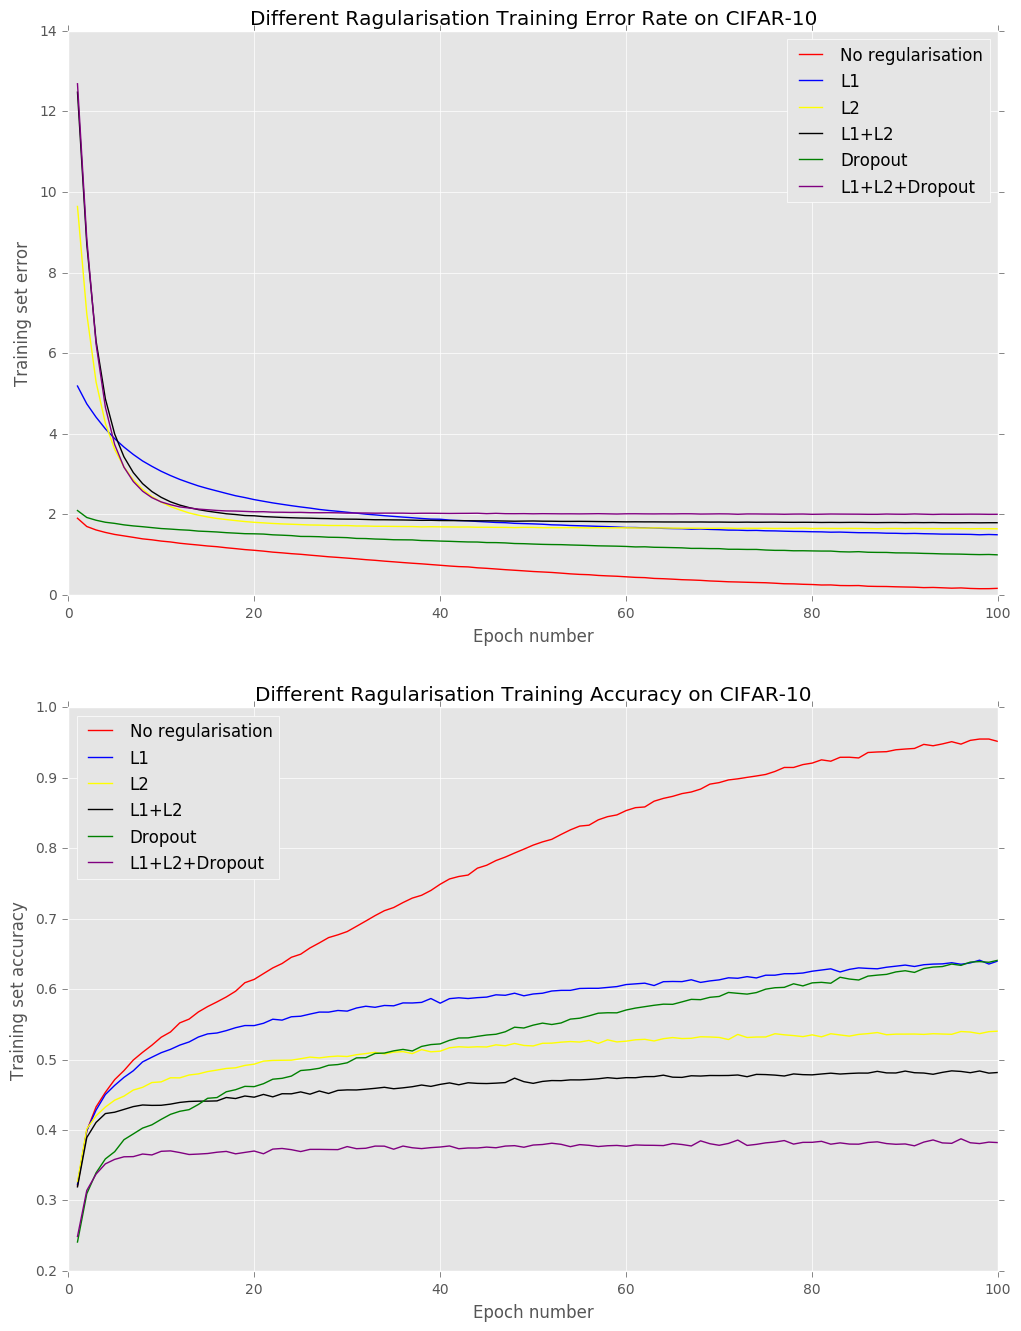

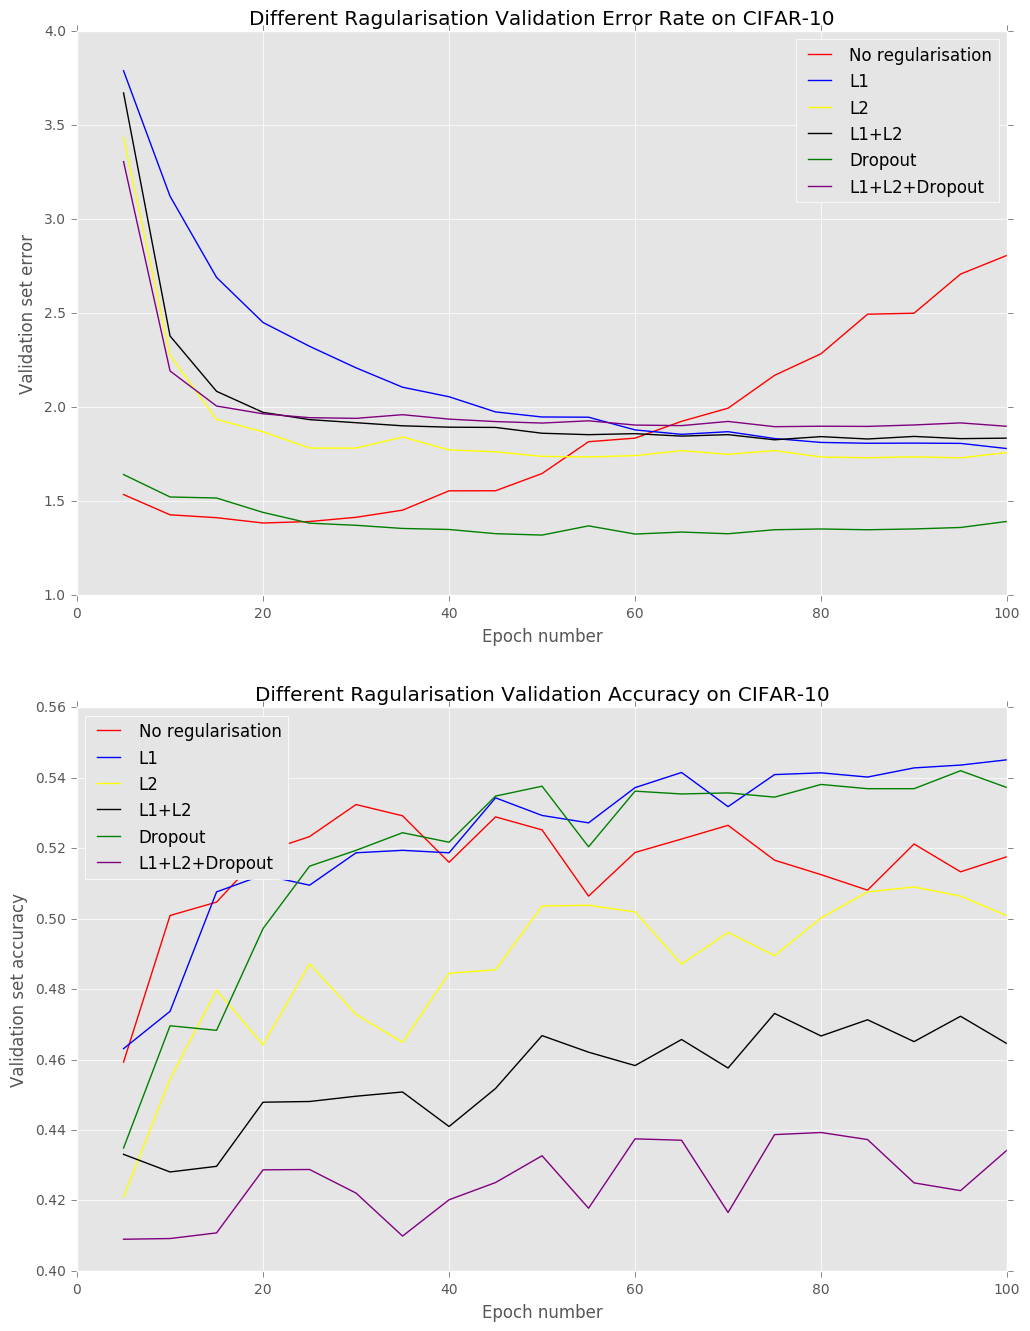

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

colorlist = ['#FF0000','#0000FF', '#FFFF00', '#000000', '#008000', '#800080', '#FFB6C1', '#FFA500']

fig1 = plt.figure(figsize=(12, 16))
ax1 = fig1.add_subplot(2, 1, 1)
ax2 = fig1.add_subplot(2, 1, 2)
ax1.plot(train_stats_ex3_6['epoch_num'], train_stats_ex3_6['error'], label='No regularisation', color=colorlist[0])
ax1.plot(train_stats_ex3_1['epoch_num'], train_stats_ex3_1['error'], label='L1', color=colorlist[1])
ax1.plot(train_stats_ex3_2['epoch_num'], train_stats_ex3_2['error'], label='L2', color=colorlist[2])
ax1.plot(train_stats_ex3_3['epoch_num'], train_stats_ex3_3['error'], label='L1+L2', color=colorlist[3])
ax1.plot(train_stats_ex3_4['epoch_num'], train_stats_ex3_4['error'], label='Dropout', color=colorlist[4])
ax1.plot(train_stats_ex3_5['epoch_num'], train_stats_ex3_5['error'], label='L1+L2+Dropout', color=colorlist[5])

ax2.plot(train_stats_ex3_6['epoch_num'], train_stats_ex3_6['acc'], label='No regularisation', color=colorlist[0])
ax2.plot(train_stats_ex3_1['epoch_num'], train_stats_ex3_1['acc'], label='L1', color=colorlist[1])
ax2.plot(train_stats_ex3_2['epoch_num'], train_stats_ex3_2['acc'], label='L2', color=colorlist[2])
ax2.plot(train_stats_ex3_3['epoch_num'], train_stats_ex3_3['acc'], label='L1+L2', color=colorlist[3])
ax2.plot(train_stats_ex3_4['epoch_num'], train_stats_ex3_4['acc'], label='Dropout', color=colorlist[4])
ax2.plot(train_stats_ex3_5['epoch_num'], train_stats_ex3_5['acc'], label='L1+L2+Dropout', color=colorlist[5])

ax1.set_title('Different Ragularisation Training Error Rate on CIFAR-10')
ax1.legend(loc='best')
ax1.set_xlabel('Epoch number')
ax1.set_ylabel('Training set error')

ax2.set_title('Different Ragularisation Training Accuracy on CIFAR-10')
ax2.legend(loc='best')
ax2.set_xlabel('Epoch number')
ax2.set_ylabel('Training set accuracy')

plt.show()
fig1.tight_layout()
fig1.savefig('ex_3_fig_1.pdf')

fig2 = plt.figure(figsize=(12, 16))
ax1 = fig2.add_subplot(2, 1, 1)
ax2 = fig2.add_subplot(2, 1, 2)
ax1.plot(valid_stats_ex3_6['epoch_num'], valid_stats_ex3_6['error'], label='No regularisation', color=colorlist[0])
ax1.plot(valid_stats_ex3_1['epoch_num'], valid_stats_ex3_1['error'], label='L1', color=colorlist[1])
ax1.plot(valid_stats_ex3_2['epoch_num'], valid_stats_ex3_2['error'], label='L2', color=colorlist[2])
ax1.plot(valid_stats_ex3_3['epoch_num'], valid_stats_ex3_3['error'], label='L1+L2', color=colorlist[3])
ax1.plot(valid_stats_ex3_4['epoch_num'], valid_stats_ex3_4['error'], label='Dropout', color=colorlist[4])
ax1.plot(valid_stats_ex3_5['epoch_num'], valid_stats_ex3_5['error'], label='L1+L2+Dropout', color=colorlist[5])

ax2.plot(valid_stats_ex3_6['epoch_num'], valid_stats_ex3_6['acc'], label='No regularisation', color=colorlist[0])
ax2.plot(valid_stats_ex3_1['epoch_num'], valid_stats_ex3_1['acc'], label='L1', color=colorlist[1])
ax2.plot(valid_stats_ex3_2['epoch_num'], valid_stats_ex3_2['acc'], label='L2', color=colorlist[2])
ax2.plot(valid_stats_ex3_3['epoch_num'], valid_stats_ex3_3['acc'], label='L1+L2', color=colorlist[3])
ax2.plot(valid_stats_ex3_4['epoch_num'], valid_stats_ex3_4['acc'], label='Dropout', color=colorlist[4])
ax2.plot(valid_stats_ex3_5['epoch_num'], valid_stats_ex3_5['acc'], label='L1+L2+Dropout', color=colorlist[5])

ax1.set_title('Different Ragularisation Validation Error Rate on CIFAR-10')
ax1.legend(loc='best')
ax1.set_xlabel('Epoch number')
ax1.set_ylabel('Validation set error')

ax2.set_title('Different Ragularisation Validation Accuracy on CIFAR-10')
ax2.legend(loc='best')
ax2.set_xlabel('Epoch number')
ax2.set_ylabel('Validation set accuracy')

plt.show()
fig2.tight_layout()
fig2.savefig('ex_3_fig_2.pdf')

### Experiment 4:  Exploring different learning rate schedules

In [18]:
seed = 24102016 
rng = np.random.RandomState(seed)
train_data = CIFAR10DataProvider('train', batch_size=50, rng=rng)
valid_data = CIFAR10DataProvider('valid', batch_size=50, rng=rng)

#### 4-1. Using  no learning rate schedules with GradientDescentOptimizeron CIFAR-10

In [19]:
def fully_connected_layer(inputs, input_dim, output_dim, nonlinearity=tf.nn.relu):
    weights = tf.Variable(
        tf.truncated_normal(
            [input_dim, output_dim], stddev=2. / (input_dim + output_dim)**0.5), 
        'weights')
    biases = tf.Variable(tf.zeros([output_dim]), 'biases')
    outputs = nonlinearity(tf.matmul(inputs, weights) + biases)
    return outputs

train_data.reset()
valid_data.reset()
tf.reset_default_graph()

inputs = tf.placeholder(tf.float32, [None, train_data.inputs.shape[1]], 'inputs')
targets = tf.placeholder(tf.float32, [None, train_data.num_classes], 'targets')
#note
num_hidden = 300

#note
with tf.name_scope('fc-layer-1'):
    hidden_1 = fully_connected_layer(inputs, train_data.inputs.shape[1], num_hidden)
with tf.name_scope('fc-layer-2'):
    hidden_2 = fully_connected_layer(hidden_1, num_hidden, num_hidden)
with tf.name_scope('fc-layer-3'):
    hidden_3 = fully_connected_layer(hidden_2, num_hidden, num_hidden)
with tf.name_scope('output-layer'):
    outputs = fully_connected_layer(hidden_3, num_hidden, train_data.num_classes, tf.identity)

with tf.name_scope('error'):
    error = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(outputs, targets))
with tf.name_scope('accuracy'):
    accuracy = tf.reduce_mean(tf.cast(
            tf.equal(tf.argmax(outputs, 1), tf.argmax(targets, 1)), 
            tf.float32))
#note
with tf.name_scope('train'):
    train_step = tf.train.GradientDescentOptimizer(learning_rate = 0.01).minimize(error)
    
init = tf.global_variables_initializer()

In [20]:
#note
train_stats_ex4_1 = {'epoch_num':[], 'error':[], 'acc':[], 'runningtime':[]}
valid_stats_ex4_1 = {'epoch_num':[], 'error':[], 'acc':[], 'runningtime':[]}
with tf.Session() as sess:
    sess.run(init)
    valid_time = 0.
    #note
    for e in range(100):
        start_time = time.time()
        if valid_time == 0.:
            valid_time = time.time()
        running_error = 0.
        running_accuracy = 0.
        for input_batch, target_batch in train_data:
            _, batch_error, batch_acc = sess.run(
                [train_step, error, accuracy], 
                feed_dict={inputs: input_batch, targets: target_batch})
            running_error += batch_error
            running_accuracy += batch_acc
        running_error /= train_data.num_batches
        running_accuracy /= train_data.num_batches
        epoch_time = time.time() - start_time
        #note
        train_stats_ex4_1['runningtime'].append(epoch_time)
        print('Epoch {0:02d}: {1:.2f}s to complete'.format(e + 1, epoch_time))
        print('End of epoch {0:02d}: err(train)={1:.2f} acc(train)={2:.2f}'
              .format(e + 1, running_error, running_accuracy))
        train_stats_ex4_1['epoch_num'].append(e + 1)
        train_stats_ex4_1['error'].append(running_error)
        train_stats_ex4_1['acc'].append(running_accuracy)
        if (e + 1) % 5 == 0:
            valid_error = 0.
            valid_accuracy = 0.
            for input_batch, target_batch in valid_data:
                batch_error, batch_acc = sess.run(
                    [error, accuracy], 
                    feed_dict={inputs: input_batch, targets: target_batch})
                valid_error += batch_error
                valid_accuracy += batch_acc
            valid_error /= valid_data.num_batches
            valid_accuracy /= valid_data.num_batches
            valid_time = time.time() - valid_time
            print('                 err(valid)={0:.2f} acc(valid)={1:.2f}'
                   .format(valid_error, valid_accuracy))
            #note
            valid_stats_ex4_1['epoch_num'].append(e + 1)
            valid_stats_ex4_1['error'].append(valid_error)
            valid_stats_ex4_1['acc'].append(valid_accuracy)
            valid_stats_ex4_1['runningtime'].append(valid_time)
            valid_time = 0.

Epoch 01: 10.18s to complete
End of epoch 01: err(train)=1.89 acc(train)=0.32
Epoch 02: 10.40s to complete
End of epoch 02: err(train)=1.71 acc(train)=0.40
Epoch 03: 10.16s to complete
End of epoch 03: err(train)=1.63 acc(train)=0.42
Epoch 04: 10.19s to complete
End of epoch 04: err(train)=1.57 acc(train)=0.44
Epoch 05: 10.13s to complete
End of epoch 05: err(train)=1.53 acc(train)=0.46
                 err(valid)=1.57 acc(valid)=0.45
Epoch 06: 10.19s to complete
End of epoch 06: err(train)=1.49 acc(train)=0.47
Epoch 07: 10.15s to complete
End of epoch 07: err(train)=1.46 acc(train)=0.48
Epoch 08: 10.34s to complete
End of epoch 08: err(train)=1.43 acc(train)=0.49
Epoch 09: 10.55s to complete
End of epoch 09: err(train)=1.40 acc(train)=0.50
Epoch 10: 10.34s to complete
End of epoch 10: err(train)=1.38 acc(train)=0.51
                 err(valid)=1.50 acc(valid)=0.47
Epoch 11: 10.25s to complete
End of epoch 11: err(train)=1.36 acc(train)=0.52
Epoch 12: 10.33s to complete
End of epoch 12

#### 4-2. Using exponential decay to learning rate with GradientDescentOptimizeron on CIFAR-10

In [21]:
def fully_connected_layer(inputs, input_dim, output_dim, nonlinearity=tf.nn.relu):
    weights = tf.Variable(
        tf.truncated_normal(
            [input_dim, output_dim], stddev=2. / (input_dim + output_dim)**0.5), 
        'weights')
    biases = tf.Variable(tf.zeros([output_dim]), 'biases')
    outputs = nonlinearity(tf.matmul(inputs, weights) + biases)
    return outputs

train_data.reset()
valid_data.reset()
tf.reset_default_graph()

inputs = tf.placeholder(tf.float32, [None, train_data.inputs.shape[1]], 'inputs')
targets = tf.placeholder(tf.float32, [None, train_data.num_classes], 'targets')
#note
num_hidden = 300

#note
with tf.name_scope('fc-layer-1'):
    hidden_1 = fully_connected_layer(inputs, train_data.inputs.shape[1], num_hidden)
with tf.name_scope('fc-layer-2'):
    hidden_2 = fully_connected_layer(hidden_1, num_hidden, num_hidden)
with tf.name_scope('fc-layer-3'):
    hidden_3 = fully_connected_layer(hidden_2, num_hidden, num_hidden)
with tf.name_scope('output-layer'):
    outputs = fully_connected_layer(hidden_3, num_hidden, train_data.num_classes, tf.identity)

with tf.name_scope('error'):
    error = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(outputs, targets))
with tf.name_scope('accuracy'):
    accuracy = tf.reduce_mean(tf.cast(
            tf.equal(tf.argmax(outputs, 1), tf.argmax(targets, 1)), 
            tf.float32))
#note
with tf.name_scope('learning-rate-schedules'):
    global_step = tf.Variable(0, trainable=False)
    starter_learning_rate = 0.01
    learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step,
                                           10000, 0.96, staircase=True)
with tf.name_scope('train'):
    train_step = tf.train.GradientDescentOptimizer(learning_rate = learning_rate).minimize(error)
    
init = tf.global_variables_initializer()

In [22]:
#note
train_stats_ex4_2 = {'epoch_num':[], 'error':[], 'acc':[], 'runningtime':[]}
valid_stats_ex4_2 = {'epoch_num':[], 'error':[], 'acc':[], 'runningtime':[]}
with tf.Session() as sess:
    sess.run(init)
    valid_time = 0.
    #note
    for e in range(100):
        start_time = time.time()
        if valid_time == 0.:
            valid_time = time.time()
        running_error = 0.
        running_accuracy = 0.
        for input_batch, target_batch in train_data:
            _, batch_error, batch_acc = sess.run(
                [train_step, error, accuracy], 
                feed_dict={inputs: input_batch, targets: target_batch})
            running_error += batch_error
            running_accuracy += batch_acc
        running_error /= train_data.num_batches
        running_accuracy /= train_data.num_batches
        epoch_time = time.time() - start_time
        #note
        train_stats_ex4_2['runningtime'].append(epoch_time)
        print('Epoch {0:02d}: {1:.2f}s to complete'.format(e + 1, epoch_time))
        print('End of epoch {0:02d}: err(train)={1:.2f} acc(train)={2:.2f}'
              .format(e + 1, running_error, running_accuracy))
        train_stats_ex4_2['epoch_num'].append(e + 1)
        train_stats_ex4_2['error'].append(running_error)
        train_stats_ex4_2['acc'].append(running_accuracy)
        if (e + 1) % 5 == 0:
            valid_error = 0.
            valid_accuracy = 0.
            for input_batch, target_batch in valid_data:
                batch_error, batch_acc = sess.run(
                    [error, accuracy], 
                    feed_dict={inputs: input_batch, targets: target_batch})
                valid_error += batch_error
                valid_accuracy += batch_acc
            valid_error /= valid_data.num_batches
            valid_accuracy /= valid_data.num_batches
            valid_time = time.time() - valid_time
            print('                 err(valid)={0:.2f} acc(valid)={1:.2f}'
                   .format(valid_error, valid_accuracy))
            #note
            valid_stats_ex4_2['epoch_num'].append(e + 1)
            valid_stats_ex4_2['error'].append(valid_error)
            valid_stats_ex4_2['acc'].append(valid_accuracy)
            valid_stats_ex4_2['runningtime'].append(valid_time)
            valid_time = 0.

Epoch 01: 10.18s to complete
End of epoch 01: err(train)=1.90 acc(train)=0.32
Epoch 02: 10.32s to complete
End of epoch 02: err(train)=1.72 acc(train)=0.39
Epoch 03: 10.21s to complete
End of epoch 03: err(train)=1.63 acc(train)=0.42
Epoch 04: 10.39s to complete
End of epoch 04: err(train)=1.58 acc(train)=0.44
Epoch 05: 10.26s to complete
End of epoch 05: err(train)=1.53 acc(train)=0.46
                 err(valid)=1.54 acc(valid)=0.46
Epoch 06: 10.12s to complete
End of epoch 06: err(train)=1.49 acc(train)=0.47
Epoch 07: 10.13s to complete
End of epoch 07: err(train)=1.46 acc(train)=0.48
Epoch 08: 10.18s to complete
End of epoch 08: err(train)=1.43 acc(train)=0.49
Epoch 09: 10.61s to complete
End of epoch 09: err(train)=1.40 acc(train)=0.50
Epoch 10: 10.07s to complete
End of epoch 10: err(train)=1.38 acc(train)=0.51
                 err(valid)=1.45 acc(valid)=0.49
Epoch 11: 10.13s to complete
End of epoch 11: err(train)=1.36 acc(train)=0.52
Epoch 12: 10.11s to complete
End of epoch 12

#### 4-3. Using inverse time decay to learning rate with GradientDescentOptimizeron on CIFAR-10

In [24]:
def fully_connected_layer(inputs, input_dim, output_dim, nonlinearity=tf.nn.relu):
    weights = tf.Variable(
        tf.truncated_normal(
            [input_dim, output_dim], stddev=2. / (input_dim + output_dim)**0.5), 
        'weights')
    biases = tf.Variable(tf.zeros([output_dim]), 'biases')
    outputs = nonlinearity(tf.matmul(inputs, weights) + biases)
    return outputs

train_data.reset()
valid_data.reset()
tf.reset_default_graph()

inputs = tf.placeholder(tf.float32, [None, train_data.inputs.shape[1]], 'inputs')
targets = tf.placeholder(tf.float32, [None, train_data.num_classes], 'targets')
#note
num_hidden = 300

#note
with tf.name_scope('fc-layer-1'):
    hidden_1 = fully_connected_layer(inputs, train_data.inputs.shape[1], num_hidden)
with tf.name_scope('fc-layer-2'):
    hidden_2 = fully_connected_layer(hidden_1, num_hidden, num_hidden)
with tf.name_scope('fc-layer-3'):
    hidden_3 = fully_connected_layer(hidden_2, num_hidden, num_hidden)
with tf.name_scope('output-layer'):
    outputs = fully_connected_layer(hidden_3, num_hidden, train_data.num_classes, tf.identity)

with tf.name_scope('error'):
    error = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(outputs, targets))
with tf.name_scope('accuracy'):
    accuracy = tf.reduce_mean(tf.cast(
            tf.equal(tf.argmax(outputs, 1), tf.argmax(targets, 1)), 
            tf.float32))
#note
with tf.name_scope('learning-rate-schedules'):
    global_step = tf.Variable(0, trainable=False)
    starter_learning_rate = 0.01
    k = 0.5
    learning_rate = tf.train.inverse_time_decay(starter_learning_rate, global_step, 10000,k)
with tf.name_scope('train'):
    train_step = tf.train.GradientDescentOptimizer(learning_rate = learning_rate).minimize(error)
    
init = tf.global_variables_initializer()

In [25]:
#note
train_stats_ex4_3 = {'epoch_num':[], 'error':[], 'acc':[], 'runningtime':[]}
valid_stats_ex4_3 = {'epoch_num':[], 'error':[], 'acc':[], 'runningtime':[]}
with tf.Session() as sess:
    sess.run(init)
    valid_time = 0.
    #note
    for e in range(100):
        start_time = time.time()
        if valid_time == 0.:
            valid_time = time.time()
        running_error = 0.
        running_accuracy = 0.
        for input_batch, target_batch in train_data:
            _, batch_error, batch_acc = sess.run(
                [train_step, error, accuracy], 
                feed_dict={inputs: input_batch, targets: target_batch})
            running_error += batch_error
            running_accuracy += batch_acc
        running_error /= train_data.num_batches
        running_accuracy /= train_data.num_batches
        epoch_time = time.time() - start_time
        #note
        train_stats_ex4_3['runningtime'].append(epoch_time)
        print('Epoch {0:02d}: {1:.2f}s to complete'.format(e + 1, epoch_time))
        print('End of epoch {0:02d}: err(train)={1:.2f} acc(train)={2:.2f}'
              .format(e + 1, running_error, running_accuracy))
        train_stats_ex4_3['epoch_num'].append(e + 1)
        train_stats_ex4_3['error'].append(running_error)
        train_stats_ex4_3['acc'].append(running_accuracy)
        if (e + 1) % 5 == 0:
            valid_error = 0.
            valid_accuracy = 0.
            for input_batch, target_batch in valid_data:
                batch_error, batch_acc = sess.run(
                    [error, accuracy], 
                    feed_dict={inputs: input_batch, targets: target_batch})
                valid_error += batch_error
                valid_accuracy += batch_acc
            valid_error /= valid_data.num_batches
            valid_accuracy /= valid_data.num_batches
            valid_time = time.time() - valid_time
            print('                 err(valid)={0:.2f} acc(valid)={1:.2f}'
                   .format(valid_error, valid_accuracy))
            #note
            valid_stats_ex4_3['epoch_num'].append(e + 1)
            valid_stats_ex4_3['error'].append(valid_error)
            valid_stats_ex4_3['acc'].append(valid_accuracy)
            valid_stats_ex4_3['runningtime'].append(valid_time)
            valid_time = 0.

Epoch 01: 10.88s to complete
End of epoch 01: err(train)=1.90 acc(train)=0.32
Epoch 02: 10.39s to complete
End of epoch 02: err(train)=1.71 acc(train)=0.39
Epoch 03: 10.76s to complete
End of epoch 03: err(train)=1.63 acc(train)=0.42
Epoch 04: 10.32s to complete
End of epoch 04: err(train)=1.58 acc(train)=0.44
Epoch 05: 10.06s to complete
End of epoch 05: err(train)=1.54 acc(train)=0.46
                 err(valid)=1.60 acc(valid)=0.43
Epoch 06: 9.94s to complete
End of epoch 06: err(train)=1.50 acc(train)=0.47
Epoch 07: 9.96s to complete
End of epoch 07: err(train)=1.47 acc(train)=0.48
Epoch 08: 10.03s to complete
End of epoch 08: err(train)=1.44 acc(train)=0.49
Epoch 09: 9.98s to complete
End of epoch 09: err(train)=1.41 acc(train)=0.50
Epoch 10: 9.98s to complete
End of epoch 10: err(train)=1.39 acc(train)=0.51
                 err(valid)=1.48 acc(valid)=0.48
Epoch 11: 9.91s to complete
End of epoch 11: err(train)=1.37 acc(train)=0.52
Epoch 12: 9.92s to complete
End of epoch 12: err(

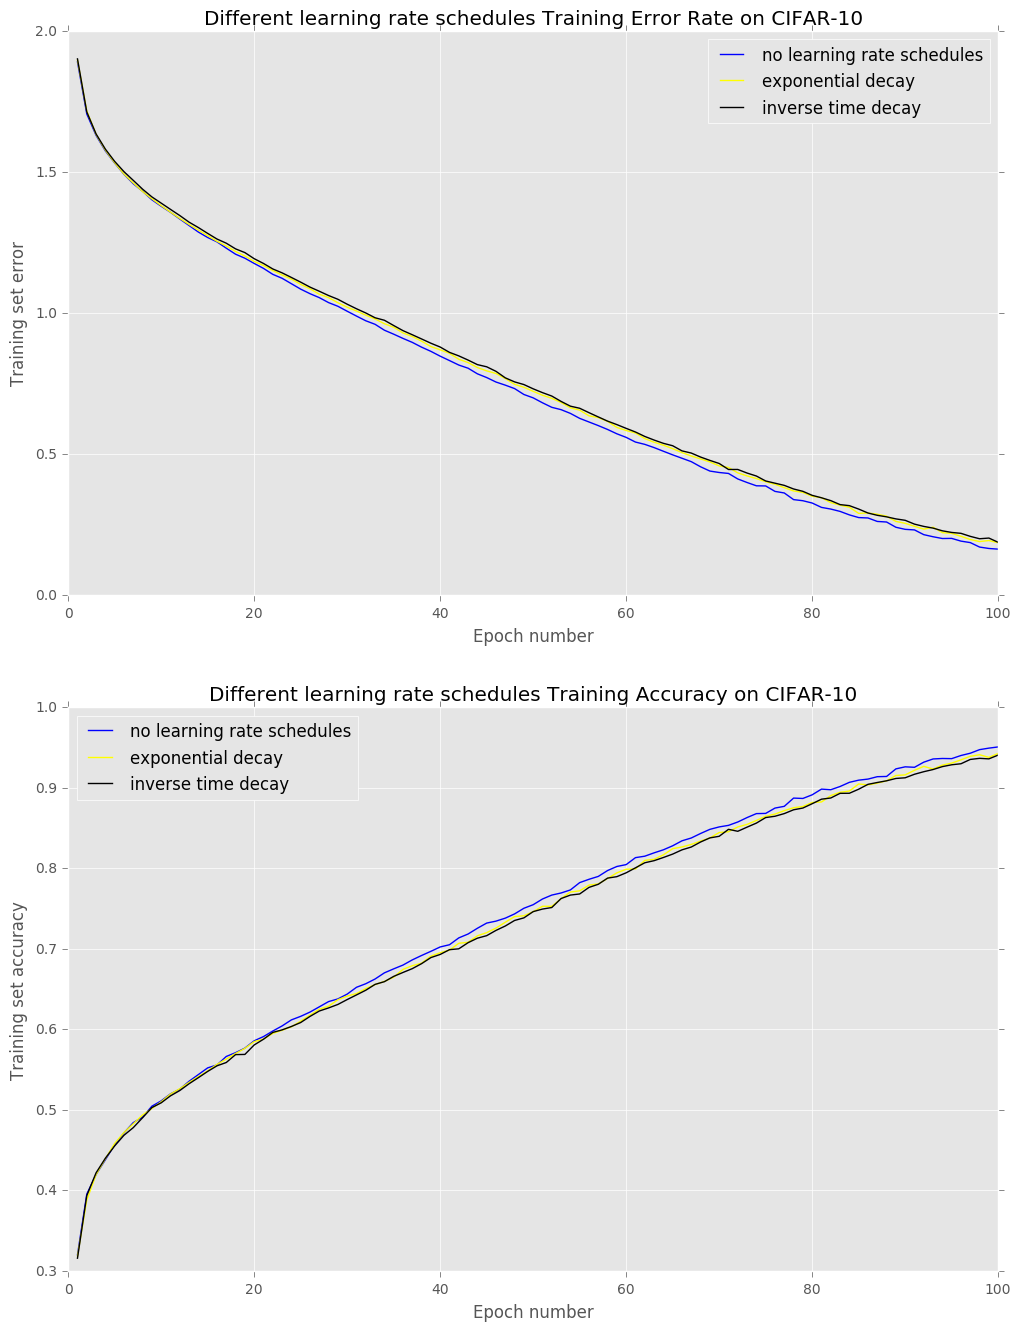

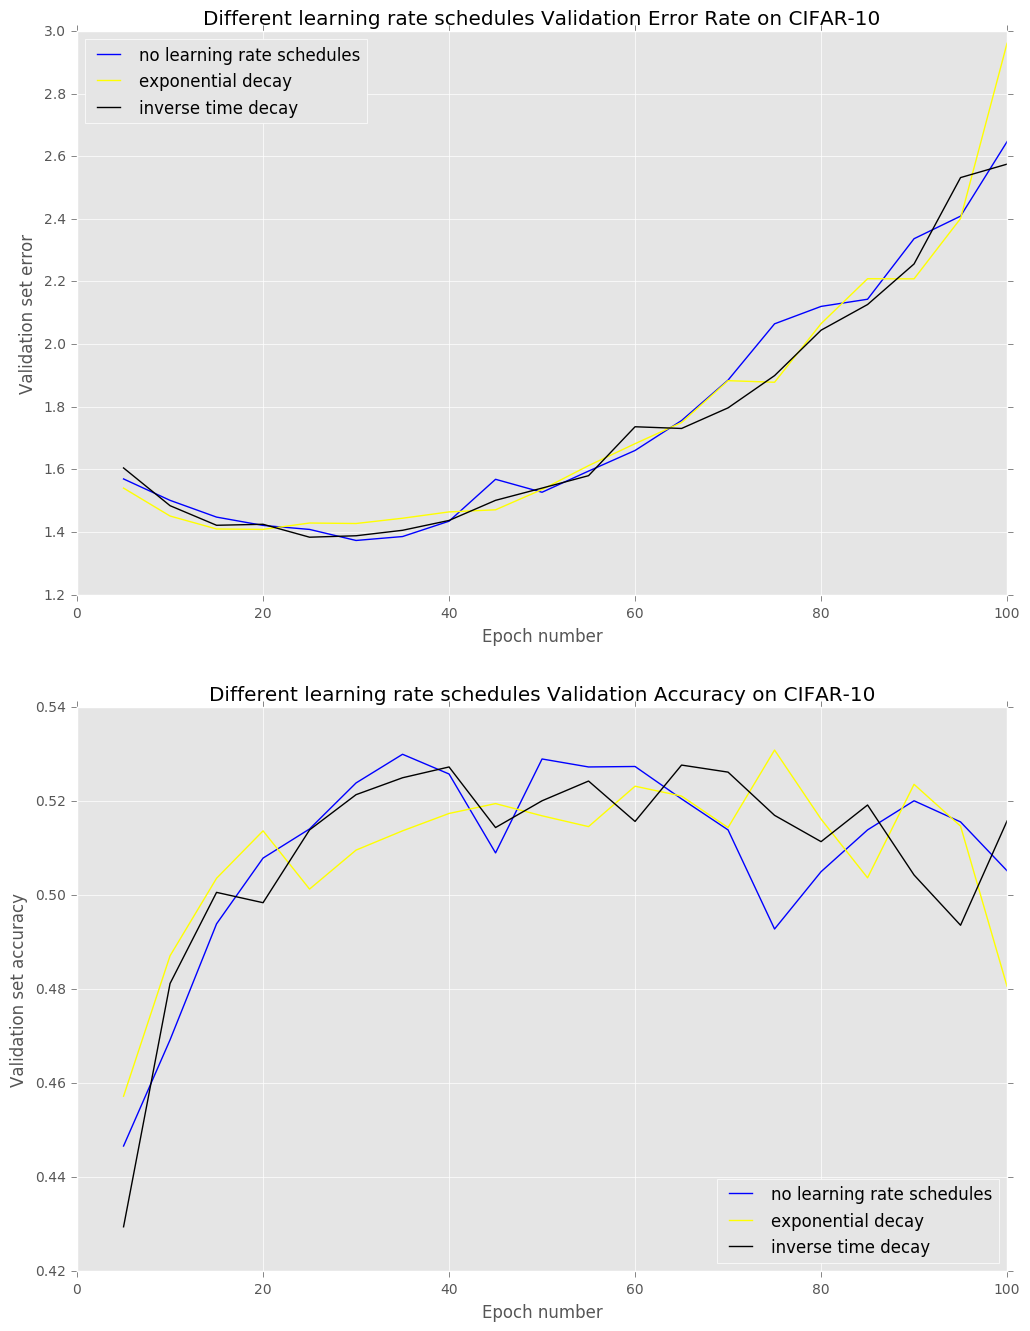

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

colorlist = ['#FF0000','#0000FF', '#FFFF00', '#000000', '#008000', '#800080', '#FFB6C1', '#FFA500']

fig1 = plt.figure(figsize=(12, 16))
ax1 = fig1.add_subplot(2, 1, 1)
ax2 = fig1.add_subplot(2, 1, 2)

ax1.plot(train_stats_ex4_1['epoch_num'], train_stats_ex4_1['error'], label='no learning rate schedules', color=colorlist[1])
ax1.plot(train_stats_ex4_2['epoch_num'], train_stats_ex4_2['error'], label='exponential decay', color=colorlist[2])
ax1.plot(train_stats_ex4_3['epoch_num'], train_stats_ex4_3['error'], label='inverse time decay', color=colorlist[3])

ax2.plot(train_stats_ex4_1['epoch_num'], train_stats_ex4_1['acc'], label='no learning rate schedules', color=colorlist[1])
ax2.plot(train_stats_ex4_2['epoch_num'], train_stats_ex4_2['acc'], label='exponential decay', color=colorlist[2])
ax2.plot(train_stats_ex4_3['epoch_num'], train_stats_ex4_3['acc'], label='inverse time decay', color=colorlist[3])

ax1.set_title('Different learning rate schedules Training Error Rate on CIFAR-10')
ax1.legend(loc='best')
ax1.set_xlabel('Epoch number')
ax1.set_ylabel('Training set error')

ax2.set_title('Different learning rate schedules Training Accuracy on CIFAR-10')
ax2.legend(loc='best')
ax2.set_xlabel('Epoch number')
ax2.set_ylabel('Training set accuracy')

plt.show()
fig1.tight_layout()
fig1.savefig('ex_4_fig_1.pdf')

fig2 = plt.figure(figsize=(12, 16))
ax1 = fig2.add_subplot(2, 1, 1)
ax2 = fig2.add_subplot(2, 1, 2)
ax1.plot(valid_stats_ex4_1['epoch_num'], valid_stats_ex4_1['error'], label='no learning rate schedules', color=colorlist[1])
ax1.plot(valid_stats_ex4_2['epoch_num'], valid_stats_ex4_2['error'], label='exponential decay', color=colorlist[2])
ax1.plot(valid_stats_ex4_3['epoch_num'], valid_stats_ex4_3['error'], label='inverse time decay', color=colorlist[3])

ax2.plot(valid_stats_ex4_1['epoch_num'], valid_stats_ex4_1['acc'], label='no learning rate schedules', color=colorlist[1])
ax2.plot(valid_stats_ex4_2['epoch_num'], valid_stats_ex4_2['acc'], label='exponential decay', color=colorlist[2])
ax2.plot(valid_stats_ex4_3['epoch_num'], valid_stats_ex4_3['acc'], label='inverse time decay', color=colorlist[3])

ax1.set_title('Different learning rate schedules Validation Error Rate on CIFAR-10')
ax1.legend(loc='best')
ax1.set_xlabel('Epoch number')
ax1.set_ylabel('Validation set error')

ax2.set_title('Different learning rate schedules Validation Accuracy on CIFAR-10')
ax2.legend(loc='best')
ax2.set_xlabel('Epoch number')
ax2.set_ylabel('Validation set accuracy')

plt.show()
fig2.tight_layout()
fig2.savefig('ex_4_fig_2.pdf')